# Loading Packages

In [ ]:
# !pip3 install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install imblearn

In [1]:
# Basic Python Packages
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Torch Packages
import torch
import torchvision
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

# ML Test and Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Other
import cv2
from tqdm import tqdm
from copy import deepcopy

# Our functions
from processing_functions import *

# Making the Segmented Teeth Data

Once all of the data is added this cell needs to be run just once to segement all the teeth and create the data.csv.

In [ ]:
# Run this cell once

# # Global vars for loading data
# which_anomaly = [0, 1, 2, 3, 4, 5, 6, 8]
# output_path = 'C:/Documents/Dental_Detection/Segmented_Images_3/'

# # Path
# xray_path = 'D:/dental_training_images/images/'
# anomaly_path = 'D:/dental_training_images/labels/'
# segmentation_path = 'D:/dental_training_images/segments/'


# make_data(xray_path, anomaly_path, segmentation_path, output_path, which_anomaly=which_anomaly,
#               add_rotation=True, rotation_deg=20, add_flip=True, add_noise=True, sigma_noise=0.1,
#               add_blur=True, sigma_blur=1)

## Check Made Data and CSV

In [2]:
df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/segmented_data.csv')

In [3]:
df.shape

(33425, 7)

In [4]:
# How many files are in the image directory
print(len(os.listdir('C:/Documents/Dental_Detection/Segmented_Images_3/')))

33425


In [5]:
df.groupby('anomaly_code').count()

,Unnamed: 0,file_path,is_rotated,is_flipped,is_noise,is_blur
anomaly_code,,,,,,
0.0,19448,19448,19448,19448,19448,19448
1.0,1694,1694,1694,1694,1694,1694
2.0,506,506,506,506,506,506
3.0,220,220,220,220,220,220
4.0,1122,1122,1122,1122,1122,1122
5.0,1122,1122,1122,1122,1122,1122
6.0,1738,1738,1738,1738,1738,1738
7.0,5573,5573,5573,5573,5573,5573
8.0,2002,2002,2002,2002,2002,2002


# Class Definitions

## _Smote_

In [6]:
class TeethDataLoader_wSMOTE(data.Dataset): 
    
    def __init__(self, train_dataloader):
        self.images, self.labels = SMOTE_Balance(train_dataloader)
           
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]               # class # 
        
        return img.float(), torch.FloatTensor([label]) # returns tensor of modified image and label

## _TeethDataLoader_Simplified_

In [7]:
class TeethDataLoader_Simplified(data.Dataset):
    
    def __init__(self, path_to_df, anomalies_to_include, augments_to_include):
        """
        path_to_df: the path to the main data frame ex. ~/Documents/Dental/segmented_data.csv
        anomalies_to_include: list of anomlies based on code ex. [0, 1, 2, 3, 4, 5, 6, 7, 8]
        augments_to_include: list of augment bools to include as list of 1s and Os 
                             ex. [1, 1, 1, 1] == [rotation, flip, noise, blur]
                             ex. [1, 1, 0, 0] == [rotation, flip, no noise, no blur]
        """
        # Read in data
        df = pd.read_csv(path_to_df)
        
        # Filter out which anomalies
        df = df[df['anomaly_code'].isin(anomalies_to_include)]
        
        # Filter out which augmentations to include
        include_rotations = augments_to_include[0]
        include_flips = augments_to_include[1]
        include_noise = augments_to_include[2]
        include_blur = augments_to_include[3]
        
        if(include_rotations == 0):
            df = df[df['is_rotated'] == 0]
        if(include_flips == 0):
            df = df[df['is_flipped'] == 0]
        if(include_noise == 0):
            df = df[df['is_noise'] == 0]
        if(include_blur == 0):
            df = df[df['is_blur'] == 0]
        
        self.images, self.labels = df['file_path'].tolist(), df['anomaly_code'].tolist()
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = cv2.imread(self.images[index])     # loads image from file
        img = cv2.resize(img, (224, 224))        # resize image to 224x224
        img = np.array(img, dtype=np.float32)    # change data type to float
        img = (img / 255.)                       # normalize colors to be 0-1
        img = img[:, :, (2, 1, 0)]               # reorder RGB
        img = torchvision.transforms.ToTensor()(img)  # convert to tensor
        label = self.labels[index]               # 1 or 0
        
        return img.float(), torch.FloatTensor([label]) # returns tensor of modified image and label

## Defining the Model Classes and Layers

In [8]:
class BasicConv(nn.Module):
    # initialize class
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, 
                 padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        # def conv layer, in_planes/out_planes = size of features
        self.conv = nn.Conv2d(in_planes, out_planes, 
                              kernel_size=kernel_size, stride=stride, 
                              padding=padding, dilation=dilation,
                              groups=groups, bias=bias)
        # batch normalization - normalization of the layers' inputs by re-centering and re-scaling
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        # ReLu activation
        self.relu = nn.ReLU() if relu else None

    # create feed-forward network for conv layer
    def forward(self, x):
        x = self.conv(x)           # only 1 layer
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x
 
    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1) # reshape to flatten tensor which is necessary in order to pass data into a linear layer
                                     # add -1
                                     # no flatten function in pytorch so need to create it

            
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

    
def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

       
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

       
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)
        #self.fc = nn.Linear(512 * block.expansion, 1) # linear is output of probability distributions
        self.softmax = torch.nn.Sigmoid()
        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            x = self.avgpool(x)
        else:
            x = F.avg_pool2d(x, 4)
            
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        #return F.normalize(x, dim=-1)
        return self.softmax(x)
    
def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [5, 18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)
        
    elif depth == 5:
        model = ResNet(BasicBlock, [1, 1, 2, 1], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

## Define the Train and Valid Functions

In [10]:
best_accuracy = 0

def train(train_loader, model, classes, optimizer, epoch):
    model.train()
    running_mse = 0
    batch_idx = 0
    correct, total = 0, 0
    confusion_matrix = torch.zeros(classes, classes)
 
    pd, gt = [], []
    for (x, y) in tqdm(train_loader):
        batch_idx += 1
        x = x.to(device) # move data to GPU
        y = y.to(device) # move data to GPU

        out = model(x)
        criterion = nn.CrossEntropyLoss()
        #criterion = nn.BCELoss()                    # binary cross entropy loss
        loss = criterion(out, y.squeeze(1).long())
        #loss = criterion(out.squeeze(1), y.squeeze(1)) # calculate loss based on pred output vs actuals y, 
                                                       # .squeeze removes dimensions of 1
        running_mse += loss.item() 
        optimizer.zero_grad()        # start gradient at 0
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        #predicted = (out.data > 0.5).int()

        for p in predicted:
            pd.append(p)
        for g in y.squeeze(1):
            gt.append(g)

        total += y.squeeze(1).size(0)
        correct += (predicted == y.squeeze(1)).sum().item()
        for t, p in zip(y.squeeze(1).view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
    
    pd = torch.as_tensor(pd).numpy()
    gt = torch.as_tensor(gt).numpy()

    running_mse = running_mse / batch_idx
    print('Epoch %d, loss = %.4f, batch_idx= %d' % (epoch, running_mse, batch_idx))
    print('Epoch: %d Accuracy of the Train Images: %f' %(epoch, 100 * correct / total))
    print('Confusion Matrix', np.round(confusion_matrix.cpu().numpy(), 2))
    print('Classification Report', classification_report(gt, pd))
    

def valid(valid_loader, model, classes, epoch):
    global best_accuracy
    model.eval()
    correct, total = 0, 0
    running_mse = 0
    confusion_matrix = torch.zeros(classes, classes)
    pd, gt = [], []
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x = x.to(device)
            y = y.to(device)

            out = model(x) # add .to(device) ???
            criterion = nn.CrossEntropyLoss()
            #criterion = nn.BCELoss()
            loss = criterion(out, y.squeeze(1).long())
            #loss = criterion(out.squeeze(1), y.squeeze(1))
            running_mse += loss.item()
            _, predicted = torch.max(out.data, 1)
            #predicted = (out.data > 0.5).int()

            for p in predicted:
                pd.append(p)
            for g in y.squeeze(1):
                gt.append(g)

            total += y.squeeze(1).size(0)
            correct += (predicted == y.squeeze(1)).sum().item()
            for t, p in zip(y.squeeze(1).view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    if best_accuracy < 100 * (correct/total):
        best_accuracy = 100 * (correct/total)
        
    pd = torch.as_tensor(pd).numpy()
    gt = torch.as_tensor(gt).numpy()
      
    print('Epoch: %d Accuracy of the Valid Images: %f' %(epoch, 100 * correct / total))
    print('Confusion Matrix', np.round(confusion_matrix.cpu().numpy(), 2))
    print('Classification Report', classification_report(gt, pd))

# GPU

In [11]:
# check if GPU available and assign it
torch.cuda.is_available()
device = torch.device('cuda', 1)
# device = torch.device('cpu') # this switches to CPU for debugging
device

device(type='cuda', index=1)

# Making the Models

In [12]:
# Global Variables for the Models
path_to_df = 'C:/Documents/Dental_Detection/data_csv/segmented_data.csv'
batch_size = 64
epochs = 50

## _Model 1_

In [13]:
anomalies_to_include = [0, 1, 2, 3, 4, 5, 6, 7]
augments_to_include = [0, 0, 0, 0]

num_classes_1 = len(anomalies_to_include)

model_1 = ResidualNet('ImageNet', 5, num_classes_1, 'CBAM')
model_1.to(device) # sends model to GPU
optimizer = optim.Adam(model_1.parameters(), lr=0.00003)

dataset_1 = TeethDataLoader_Simplified(path_to_df, anomalies_to_include, augments_to_include)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_1, valid_idx_1 = train_test_split(np.arange(len(dataset_1.labels)), test_size=0.2, shuffle=True, stratify=dataset_1.labels)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_1 = torch.utils.data.SubsetRandomSampler(train_idx_1)
valid_sampler_1 = torch.utils.data.SubsetRandomSampler(valid_idx_1)

# loads images associated with ids/samples from above
train_loader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=batch_size, sampler=train_sampler_1)
valid_loader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=batch_size, sampler=valid_sampler_1)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


## _Model 1 with Augments_

In [14]:
anomalies_to_include = [0, 1, 2, 3, 4, 5, 6, 7]
augments_to_include = [1, 1, 1, 1]

num_classes_1_aug = len(anomalies_to_include)

model_1_aug = ResidualNet('ImageNet', 5, num_classes_1_aug, 'CBAM')
model_1_aug.to(device) # sends model to GPU
optimizer = optim.Adam(model_1_aug.parameters(), lr=0.00003)

dataset_1_aug = TeethDataLoader_Simplified(path_to_df, anomalies_to_include, augments_to_include)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_1_aug, valid_idx_1_aug = train_test_split(np.arange(len(dataset_1_aug.labels)), test_size=0.2, shuffle=True, stratify=dataset_1_aug.labels)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_1_aug = torch.utils.data.SubsetRandomSampler(train_idx_1_aug)
valid_sampler_1_aug = torch.utils.data.SubsetRandomSampler(valid_idx_1_aug)

# loads images associated with ids/samples from above
train_loader_1_aug = torch.utils.data.DataLoader(dataset_1_aug, batch_size=batch_size, sampler=train_sampler_1_aug)
valid_loader_1_aug = torch.utils.data.DataLoader(dataset_1_aug, batch_size=batch_size, sampler=valid_sampler_1_aug)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


## _Model 1 with SMOTE_

In [ ]:
model_1_SMOTE = deepcopy(model_1)
dataset_smote_1 = TeethDataLoader_wSMOTE(train_loader_1)
train_loader_smote_1 = torch.utils.data.DataLoader(dataset_smote_1, batch_size=batch_size)

## _Model 2_

In [16]:
anomalies_to_include = [0, 1, 2, 3, 4, 5, 6, 7, 8]
augments_to_include = [0, 0, 0, 0]
num_classes_2 = len(anomalies_to_include)

model_2 = ResidualNet('ImageNet', 5, num_classes_2, 'CBAM')
model_2.to(device) # sends model to GPU
optimizer = optim.Adam(model_2.parameters(), lr=0.00003)

dataset_2 = TeethDataLoader_Simplified(path_to_df, anomalies_to_include, augments_to_include)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_2, valid_idx_2 = train_test_split(np.arange(len(dataset_2.labels)), test_size=0.2, shuffle=True, stratify=dataset_2.labels)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_2 = torch.utils.data.SubsetRandomSampler(train_idx_2)
valid_sampler_2 = torch.utils.data.SubsetRandomSampler(valid_idx_2)

# loads images associated with ids/samples from above
train_loader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=batch_size, sampler=train_sampler_2)
valid_loader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=batch_size, sampler=valid_sampler_2)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


## _Model 2 with Augments_

In [17]:
anomalies_to_include = [0, 1, 2, 3, 4, 5, 6, 7, 8]
augments_to_include = [1, 1, 1, 1]

num_classes_2_aug = len(anomalies_to_include)

model_2_aug = ResidualNet('ImageNet', 5, num_classes_2_aug, 'CBAM')
model_2_aug.to(device) # sends model to GPU
optimizer = optim.Adam(model_2_aug.parameters(), lr=0.00003)

dataset_2_aug = TeethDataLoader_Simplified(path_to_df, anomalies_to_include, augments_to_include)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_2_aug, valid_idx_2_aug = train_test_split(np.arange(len(dataset_2_aug.labels)), test_size=0.2, shuffle=True, stratify=dataset_2_aug.labels)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_2_aug = torch.utils.data.SubsetRandomSampler(train_idx_2_aug)
valid_sampler_2_aug = torch.utils.data.SubsetRandomSampler(valid_idx_2_aug)

# loads images associated with ids/samples from above
train_loader_2_aug = torch.utils.data.DataLoader(dataset_2_aug, batch_size=batch_size, sampler=train_sampler_2_aug)
valid_loader_2_aug = torch.utils.data.DataLoader(dataset_2_aug, batch_size=batch_size, sampler=valid_sampler_2_aug)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_8204/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


## _Model 2 with SMOTE_

In [ ]:
model_2_SMOTE = deepcopy(model_2)
dataset_smote_2 = TeethDataLoader_wSMOTE(train_loader_2)
train_loader_smote_2 = torch.utils.data.DataLoader(dataset_smote_2, batch_size=batch_size)

# EDA

### _Model 1_

In [18]:
print(len(dataset_1.labels))
print(len(dataset_1.images))

6748
6748


In [19]:
for i in range(0, 8):
    print(i, ":", dataset_1.labels.count(i))

0 : 884
1 : 77
2 : 23
3 : 10
4 : 51
5 : 51
6 : 79
7 : 5573


Text(0, 0.5, 'count')

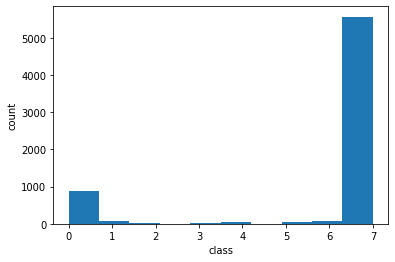

In [20]:
plt.hist(dataset_1.labels)
plt.xlabel('class')
plt.ylabel('count')

### _Model 2_

In [21]:
print(len(dataset_2.labels))
print(len(dataset_2.images))

6839
6839


In [22]:
for i in range(0, 9):
    print(i, ":", dataset_2.labels.count(i))

0 : 884
1 : 77
2 : 23
3 : 10
4 : 51
5 : 51
6 : 79
7 : 5573
8 : 91


Text(0, 0.5, 'count')

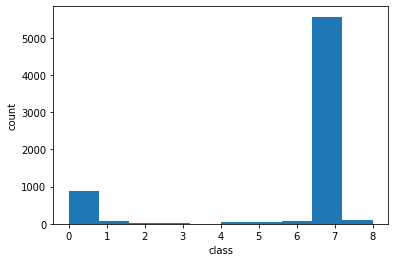

In [23]:
plt.hist(dataset_2.labels)
plt.xlabel('class')
plt.ylabel('count')

# Run Model

### _Model 1_

In [ ]:
for epoch in range(1, epochs+1):
    train(train_loader_1, model_1, num_classes_1, optimizer, epoch)
    valid(valid_loader_1, model_1, num_classes_1, epoch)

In [ ]:
PATH = 'model_1.pth'
torch.save(model_1.state_dict(), PATH)

### _Model 1 with Augments_

In [24]:
for epoch in range(1, epochs+1):
    train(train_loader_1_aug, model_1_aug, num_classes_1_aug, optimizer, epoch)
    valid(valid_loader_1_aug, model_1_aug, num_classes_1_aug, epoch)

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [02:06<00:00,  3.11it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 1, loss = 2.1372, batch_idx= 393
Epoch: 1 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3880e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 7.0000e+00 0.0000e+00
  0.0000e+00 4.4510e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:26<00:00,  3.70it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 1 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.51it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 2, loss = 2.1371, batch_idx= 393
Epoch: 2 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 2 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.50it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 3, loss = 2.1371, batch_idx= 393
Epoch: 3 Accuracy of the Train Images: 17.726152
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.5557e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3520e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4560e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 3 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 4, loss = 2.1371, batch_idx= 393
Epoch: 4 Accuracy of the Train Images: 17.726152
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4560e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 4 Accuracy of the Valid Images: 17.724741
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  3.887e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.114e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 5, loss = 2.1372, batch_idx= 393
Epoch: 5 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3850e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 5 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.49it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 6, loss = 2.1372, batch_idx= 393
Epoch: 6 Accuracy of the Train Images: 17.686371
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.5557e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+01 0.0000e+00
  0.0000e+00 4.4460e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 6 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.49it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 7, loss = 2.1372, batch_idx= 393
Epoch: 7 Accuracy of the Train Images: 17.714218
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4530e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 7 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.49it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 8, loss = 2.1372, batch_idx= 393
Epoch: 8 Accuracy of the Train Images: 17.714218
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3880e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4530e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 8 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 9, loss = 2.1373, batch_idx= 393
Epoch: 9 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3850e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 9 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0  

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 10, loss = 2.1372, batch_idx= 393
Epoch: 10 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3880e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 10 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 11, loss = 2.1373, batch_idx= 393
Epoch: 11 Accuracy of the Train Images: 17.726152
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3880e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4560e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 11 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 12, loss = 2.1372, batch_idx= 393
Epoch: 12 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.5554e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 8.9700e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3850e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 12 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 13, loss = 2.1372, batch_idx= 393
Epoch: 13 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 1.0000e+00
  0.0000e+00 4.4510e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 13 Accuracy of the Valid Images: 17.708831
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.113e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 14, loss = 2.1373, batch_idx= 393
Epoch: 14 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3520e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 14 Accuracy of the Valid Images: 17.708831
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  3.887e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.113e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 15, loss = 2.1372, batch_idx= 393
Epoch: 15 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.5554e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 15 Accuracy of the Valid Images: 17.724741
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.114e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 16, loss = 2.1372, batch_idx= 393
Epoch: 16 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 7.0000e+00 0.0000e+00
  0.0000e+00 4.4510e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 16 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.46it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 17, loss = 2.1372, batch_idx= 393
Epoch: 17 Accuracy of the Train Images: 17.702283
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.0000e+00 0.0000e+00
  0.0000e+00 4.4500e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 17 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 18, loss = 2.1371, batch_idx= 393
Epoch: 18 Accuracy of the Train Images: 17.710239
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3880e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 4.4520e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 18 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 19, loss = 2.1372, batch_idx= 393
Epoch: 19 Accuracy of the Train Images: 17.698305
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.5557e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.0000e+00 0.0000e+00
  0.0000e+00 4.4490e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 19 Accuracy of the Valid Images: 17.724741
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.114e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 20, loss = 2.1372, batch_idx= 393
Epoch: 20 Accuracy of the Train Images: 17.710239
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.5554e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4520e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 20 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.50it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 21, loss = 2.1373, batch_idx= 393
Epoch: 21 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3520e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.3850e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 21 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.46it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 22, loss = 2.1373, batch_idx= 393
Epoch: 22 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 22 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 23, loss = 2.1372, batch_idx= 393
Epoch: 23 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.5554e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.99it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 23 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 24, loss = 2.1371, batch_idx= 393
Epoch: 24 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.000e+00 0.000e+00 0.000e+00
  1.555e+04]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.353e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.050e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.760e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.980e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.980e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.387e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 0.000e+00 0.000e+00
  4.451e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0       0.00      0.00      0.00      1355
         2.0       0.00    

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 24 Accuracy of the Valid Images: 17.708831
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  3.887e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.113e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 25, loss = 2.1372, batch_idx= 393
Epoch: 25 Accuracy of the Train Images: 17.726152
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4560e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 25 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 26, loss = 2.1372, batch_idx= 393
Epoch: 26 Accuracy of the Train Images: 17.726152
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3520e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4560e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 26 Accuracy of the Valid Images: 17.708831
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  3.887e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.113e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 27, loss = 2.1370, batch_idx= 393
Epoch: 27 Accuracy of the Train Images: 17.710239
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.3510e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3850e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 4.4520e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.98it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 27 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 28, loss = 2.1372, batch_idx= 393
Epoch: 28 Accuracy of the Train Images: 17.714218
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4530e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 28 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 29, loss = 2.1372, batch_idx= 393
Epoch: 29 Accuracy of the Train Images: 17.714218
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4530e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 29 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 30, loss = 2.1374, batch_idx= 393
Epoch: 30 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 4.4510e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 30 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.49it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 31, loss = 2.1372, batch_idx= 393
Epoch: 31 Accuracy of the Train Images: 17.714218
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4530e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 31 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 32, loss = 2.1371, batch_idx= 393
Epoch: 32 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.5554e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:10<00:00,  9.01it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 32 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.46it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 33, loss = 2.1373, batch_idx= 393
Epoch: 33 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 1.3510e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 33 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.49it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 34, loss = 2.1371, batch_idx= 393
Epoch: 34 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3520e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3890e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 34 Accuracy of the Valid Images: 17.724741
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  3.887e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.114e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 35, loss = 2.1372, batch_idx= 393
Epoch: 35 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 35 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 36, loss = 2.1374, batch_idx= 393
Epoch: 36 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 7.0000e+00 0.0000e+00
  0.0000e+00 4.4510e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.98it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 36 Accuracy of the Valid Images: 17.708831
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  3.887e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.113e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.49it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 37, loss = 2.1372, batch_idx= 393
Epoch: 37 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3880e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 37 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 38, loss = 2.1371, batch_idx= 393
Epoch: 38 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 38 Accuracy of the Valid Images: 17.724741
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  3.887e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.114e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:01<00:00,  6.44it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 39, loss = 2.1372, batch_idx= 393
Epoch: 39 Accuracy of the Train Images: 17.726152
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3880e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 4.4560e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 39 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:01<00:00,  6.44it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 40, loss = 2.1370, batch_idx= 393
Epoch: 40 Accuracy of the Train Images: 17.714218
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.5557e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4530e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 40 Accuracy of the Valid Images: 17.724741
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.114e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.45it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 41, loss = 2.1371, batch_idx= 393
Epoch: 41 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3520e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 8.9700e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 7.0000e+00 0.0000e+00
  0.0000e+00 4.4510e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 41 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 42, loss = 2.1371, batch_idx= 393
Epoch: 42 Accuracy of the Train Images: 17.706261
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 7.0000e+00 0.0000e+00
  0.0000e+00 1.5551e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 4.4510e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 42 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 43, loss = 2.1371, batch_idx= 393
Epoch: 43 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.5556e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 43 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 44, loss = 2.1373, batch_idx= 393
Epoch: 44 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.5557e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.99it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 44 Accuracy of the Valid Images: 17.724741
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.114e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 45, loss = 2.1371, batch_idx= 393
Epoch: 45 Accuracy of the Train Images: 17.710239
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.3520e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 4.4520e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 45 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 46, loss = 2.1372, batch_idx= 393
Epoch: 46 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3860e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 46 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 47, loss = 2.1372, batch_idx= 393
Epoch: 47 Accuracy of the Train Images: 17.718196
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 1.5552e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
  0.0000e+00 4.4540e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 47 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.45it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 48, loss = 2.1372, batch_idx= 393
Epoch: 48 Accuracy of the Train Images: 17.722174
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3550e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 4.4550e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 48 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.889e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.480e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 49, loss = 2.1369, batch_idx= 393
Epoch: 49 Accuracy of the Train Images: 17.714218
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 1.5555e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3540e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 4.4530e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 49 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.890e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

  0%|          | 0/393 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 393/393 [01:00<00:00,  6.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 50, loss = 2.1372, batch_idx= 393
Epoch: 50 Accuracy of the Train Images: 17.702283
Confusion Matrix [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00
  0.0000e+00 1.5553e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3530e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 4.0500e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.7600e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 8.9800e+02]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.3870e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.0000e+00 0.0000e+00
  0.0000e+00 4.4500e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15558
         1.0     

  0%|          | 0/99 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 99/99 [00:11<00:00,  8.93it/s]


Epoch: 50 Accuracy of the Valid Images: 17.740652
Confusion Matrix [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.888e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  3.380e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.240e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.470e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]]
Classification Report               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3890
         1.0       0.00      0.00      0.00       339
         2.0       0.00      0.00      0.00       101
         3.0 

C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [25]:
PATH = 'model_1_aug.pth'
torch.save(model_1_aug.state_dict(), PATH)

### _Model 1 with Smote_

In [ ]:
for epoch in range(1, epochs+1):
    train(train_loader_smote_1, model_1_SMOTE, num_classes_1, optimizer, epoch)
    valid(valid_loader_1, model_1_SMOTE, num_classes_1, epoch)

In [ ]:
PATH = 'model_1_SMOTE.pth'
torch.save(model_1_SMOTE.state_dict(), PATH)

### _Model 2_

In [ ]:
for epoch in range(1, epochs+1):
    train(train_loader_2, model_2, num_classes_2, optimizer, epoch)
    valid(valid_loader_2, model_2, num_classes_2, epoch)

In [ ]:
PATH = 'model_2.pth'
torch.save(model_2.state_dict(), PATH)

### _Model 2 with Augments_

In [26]:
for epoch in range(1, epochs+1):
    train(train_loader_2_aug, model_2_aug, num_classes_2_aug, optimizer, epoch)
    valid(valid_loader_2_aug, model_2_aug, num_classes_2_aug, epoch)

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:19<00:00,  5.27it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 1, loss = 1.7368, batch_idx= 418
Epoch: 1 Accuracy of the Train Images: 68.175019
Confusion Matrix [[1.4653e+04 5.7000e+01 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 8.4700e+02 0.0000e+00]
 [1.2370e+03 6.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 5.2000e+01 0.0000e+00]
 [3.2500e+02 7.1000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 9.0000e+00 0.0000e+00]
 [1.5300e+02 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 2.2000e+01 0.0000e+00]
 [7.5600e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.4200e+02 0.0000e+00]
 [7.5800e+02 7.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3300e+02 0.0000e+00]
 [1.1510e+03 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 2.3600e+02 0.0000e+00]
 [9.2100e+02 2.7000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 3.5100e+03 0.0000e+00]
 [1.4860e+03 8.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:13<00:00,  7.96it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 1 Accuracy of the Valid Images: 67.658938
Confusion Matrix [[3.544e+03 2.610e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.500e+01 0.000e+00]
 [1.490e+02 1.830e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00 0.000e+00]
 [2.700e+01 7.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [3.200e+01 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00 0.000e+00]
 [1.810e+02 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.200e+01 0.000e+00]
 [1.850e+02 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.800e+01 0.000e+00]
 [2.840e+02 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.500e+01 0.000e+00]
 [1.990e+02 1.210e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.950e+02 0.000e+00]
 [3.220e+02 6.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.000e+00 0.000e+00]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 2, loss = 1.6332, batch_idx= 418
Epoch: 2 Accuracy of the Train Images: 72.083022
Confusion Matrix [[1.4928e+04 2.3000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  5.0000e+00 6.0200e+02 0.0000e+00]
 [9.0500e+02 3.9300e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 5.7000e+01 0.0000e+00]
 [1.5700e+02 2.3500e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3000e+01 0.0000e+00]
 [1.3900e+02 6.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 3.1000e+01 0.0000e+00]
 [7.3800e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.6000e+02 0.0000e+00]
 [7.2300e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  2.0000e+00 1.7300e+02 0.0000e+00]
 [1.1090e+03 1.1000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  4.0000e+00 2.6600e+02 0.0000e+00]
 [4.8700e+02 1.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  5.0000e+00 3.9500e+03 0.0000e+00]
 [1.4390e+03 7.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.72it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 2 Accuracy of the Valid Images: 73.642483
Confusion Matrix [[3.754e+03 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.270e+02 0.000e+00]
 [1.520e+02 1.730e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01 0.000e+00]
 [3.300e+01 6.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [2.500e+01 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01 0.000e+00]
 [1.750e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01 0.000e+00]
 [1.820e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01 0.000e+00]
 [2.780e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.500e+01 0.000e+00]
 [1.140e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.960e+02 0.000e+00]
 [3.330e+02 4.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.900e+01 0.000e+00]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 3, loss = 1.6084, batch_idx= 418
Epoch: 3 Accuracy of the Train Images: 74.517577
Confusion Matrix [[1.4959e+04 8.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.2000e+01 5.0100e+02 0.0000e+00]
 [4.0300e+02 8.7400e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  6.0000e+00 6.6000e+01 6.0000e+00]
 [1.0100e+02 2.8900e+02 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.3000e+01 0.0000e+00]
 [1.3400e+02 1.4000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 2.8000e+01 0.0000e+00]
 [7.3100e+02 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.6500e+02 0.0000e+00]
 [7.1900e+02 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  4.0000e+00 1.7300e+02 1.0000e+00]
 [1.0550e+03 3.0000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  3.0000e+01 2.7500e+02 0.0000e+00]
 [3.9100e+02 2.7000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  5.0000e+00 4.0340e+03 1.0000e+00]
 [1.2370e+03 2.4700e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.83it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 3 Accuracy of the Valid Images: 70.725505
Confusion Matrix [[3.591e+03 1.830e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.000e+00
  6.800e+01 4.000e+01]
 [2.700e+01 2.890e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00 1.600e+01]
 [2.400e+01 7.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00]
 [3.200e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00 0.000e+00]
 [1.720e+02 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+01 1.200e+01]
 [1.740e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.800e+01 1.900e+01]
 [2.510e+02 2.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.600e+01
  4.100e+01 1.400e+01]
 [1.870e+02 3.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.010e+02 9.000e+01]
 [2.590e+02 9.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01 3.100e+01]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 4, loss = 1.5934, batch_idx= 418
Epoch: 4 Accuracy of the Train Images: 75.441286
Confusion Matrix [[1.5017e+04 8.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.7000e+01 4.3800e+02 0.0000e+00]
 [2.9300e+02 9.7300e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 5.8000e+01 3.0000e+01]
 [1.0500e+02 2.8100e+02 7.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.2000e+01 0.0000e+00]
 [1.3200e+02 1.4000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 3.0000e+01 0.0000e+00]
 [7.2500e+02 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  5.0000e+00 1.6500e+02 0.0000e+00]
 [7.1800e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  3.0000e+00 1.7300e+02 4.0000e+00]
 [1.0420e+03 3.9000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  4.6000e+01 2.6300e+02 0.0000e+00]
 [3.4200e+02 3.3000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  7.0000e+00 4.0740e+03 2.0000e+00]
 [1.1770e+03 2.8600e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.72it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 4 Accuracy of the Valid Images: 73.762154
Confusion Matrix [[3.616e+03 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.000e+00
  2.470e+02 0.000e+00]
 [7.700e+01 2.320e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+01 0.000e+00]
 [2.500e+01 7.000e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00 0.000e+00]
 [2.400e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01 0.000e+00]
 [1.700e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.400e+01 0.000e+00]
 [1.740e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.900e+01 0.000e+00]
 [2.600e+02 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.700e+01
  6.400e+01 0.000e+00]
 [4.800e+01 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.060e+03 0.000e+00]
 [2.900e+02 6.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.600e+01 5.000e+00]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 5, loss = 1.5833, batch_idx= 418
Epoch: 5 Accuracy of the Train Images: 76.106956
Confusion Matrix [[1.5071e+04 8.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  2.4000e+01 3.7500e+02 2.0000e+00]
 [2.5300e+02 1.0040e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  9.0000e+00 4.6000e+01 4.3000e+01]
 [9.9000e+01 2.8300e+02 1.0000e+01 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 1.2000e+01 0.0000e+00]
 [1.3200e+02 1.4000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 3.0000e+01 0.0000e+00]
 [7.2300e+02 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.3000e+01 1.6100e+02 0.0000e+00]
 [6.9200e+02 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  2.5000e+01 1.7200e+02 8.0000e+00]
 [9.9100e+02 3.5000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  9.3000e+01 2.7100e+02 0.0000e+00]
 [3.1800e+02 2.7000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+01 4.1020e+03 1.0000e+00]
 [1.1420e+03 3.1100e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.86it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 5 Accuracy of the Valid Images: 76.065819
Confusion Matrix [[3.735e+03 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.000e+00
  1.100e+02 1.900e+01]
 [4.600e+01 2.610e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00 2.400e+01]
 [2.600e+01 7.100e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [2.400e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01 0.000e+00]
 [1.660e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  5.200e+01 1.000e+00]
 [1.750e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  4.400e+01 2.000e+00]
 [2.600e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+01
  6.200e+01 1.000e+00]
 [7.200e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.032e+03 3.000e+00]
 [2.790e+02 7.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  9.000e+00 3.500e+01]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 6, loss = 1.5729, batch_idx= 418
Epoch: 6 Accuracy of the Train Images: 76.866118
Confusion Matrix [[1.5099e+04 8.3000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  3.9000e+01 3.3000e+02 7.0000e+00]
 [2.1400e+02 1.0390e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  5.0000e+00 4.6000e+01 5.1000e+01]
 [9.6000e+01 2.7600e+02 2.2000e+01 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.1000e+01 0.0000e+00]
 [1.2700e+02 1.4000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  2.0000e+00 3.3000e+01 0.0000e+00]
 [6.9200e+02 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  3.4000e+01 1.6900e+02 0.0000e+00]
 [6.8300e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 3.0000e+00
  2.8000e+01 1.7600e+02 7.0000e+00]
 [9.4500e+02 3.4000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.4500e+02 2.6600e+02 0.0000e+00]
 [2.6100e+02 2.9000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.1000e+01 4.1530e+03 4.0000e+00]
 [1.1160e+03 3.0900e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.79it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 6 Accuracy of the Valid Images: 77.352281
Confusion Matrix [[3.756e+03 2.800e+01 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.500e+01
  8.800e+01 1.000e+00]
 [3.400e+01 2.870e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00 1.000e+01]
 [2.600e+01 6.400e+01 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [2.600e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  9.000e+00 0.000e+00]
 [1.490e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00 2.300e+01
  4.600e+01 0.000e+00]
 [1.600e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 8.000e+00
  4.500e+01 3.000e+00]
 [2.230e+02 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.500e+01
  6.000e+01 0.000e+00]
 [7.900e+01 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.026e+03 0.000e+00]
 [2.640e+02 8.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  9.000e+00 3.100e+01]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 7, loss = 1.5651, batch_idx= 418
Epoch: 7 Accuracy of the Train Images: 77.311144
Confusion Matrix [[1.5114e+04 6.9000e+01 1.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00
  5.2000e+01 3.1300e+02 7.0000e+00]
 [1.7500e+02 1.0700e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  5.0000e+00 4.1000e+01 6.3000e+01]
 [9.1000e+01 2.6600e+02 3.7000e+01 0.0000e+00 0.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [1.3400e+02 1.4000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 2.8000e+01 0.0000e+00]
 [6.7600e+02 4.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.1000e+01
  4.0000e+01 1.6600e+02 0.0000e+00]
 [6.5700e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.6000e+01
  4.7000e+01 1.7200e+02 6.0000e+00]
 [9.1200e+02 3.3000e+01 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  1.8100e+02 2.6300e+02 0.0000e+00]
 [2.7600e+02 2.5000e+01 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  1.5000e+01 4.1410e+03 0.0000e+00]
 [1.0920e+03 3.2000e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.69it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 7 Accuracy of the Valid Images: 70.875093
Confusion Matrix [[3.270e+03 1.290e+02 1.200e+01 0.000e+00 2.000e+00 0.000e+00 2.400e+01
  1.600e+02 2.930e+02]
 [1.800e+01 2.960e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00 2.100e+01]
 [1.900e+01 7.500e+01 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.500e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.200e+01 8.000e+00]
 [1.100e+02 9.000e+00 0.000e+00 0.000e+00 1.000e+00 5.000e+00 2.000e+01
  5.300e+01 2.600e+01]
 [1.150e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 9.000e+00 9.000e+00
  4.300e+01 4.500e+01]
 [1.830e+02 1.700e+01 0.000e+00 0.000e+00 1.000e+00 4.000e+00 5.700e+01
  6.100e+01 2.500e+01]
 [2.400e+01 2.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.061e+03 3.000e+00]
 [2.400e+02 1.040e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  1.300e+01 3.800e+01]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.59it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 8, loss = 1.5566, batch_idx= 418
Epoch: 8 Accuracy of the Train Images: 78.130142
Confusion Matrix [[1.5161e+04 6.2000e+01 2.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00
  5.2000e+01 2.7000e+02 7.0000e+00]
 [1.5500e+02 1.0910e+03 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  3.0000e+00 3.2000e+01 7.3000e+01]
 [9.4000e+01 2.4700e+02 5.5000e+01 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 9.0000e+00 0.0000e+00]
 [1.2700e+02 1.4000e+01 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00
  2.0000e+00 3.1000e+01 0.0000e+00]
 [6.5900e+02 4.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 2.9000e+01
  4.4000e+01 1.5500e+02 3.0000e+00]
 [6.2700e+02 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.4000e+01
  5.0000e+01 1.6000e+02 6.0000e+00]
 [8.6900e+02 2.9000e+01 1.0000e+00 0.0000e+00 2.0000e+00 1.3000e+01
  2.1600e+02 2.6000e+02 0.0000e+00]
 [2.2000e+02 2.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  2.3000e+01 4.1830e+03 5.0000e+00]
 [1.0890e+03 3.1300e+02 1.0000e+00 0.0000e+00 0.0000e+00 3.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 8 Accuracy of the Valid Images: 77.217651
Confusion Matrix [[3.704e+03 1.800e+01 0.000e+00 0.000e+00 1.000e+00 4.000e+00 8.000e+00
  1.480e+02 7.000e+00]
 [2.800e+01 2.640e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.900e+01 1.800e+01]
 [2.100e+01 6.000e+01 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00 0.000e+00]
 [2.000e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00 0.000e+00
  1.200e+01 0.000e+00]
 [1.410e+02 0.000e+00 0.000e+00 0.000e+00 4.000e+00 1.400e+01 1.000e+01
  5.500e+01 0.000e+00]
 [1.440e+02 0.000e+00 0.000e+00 0.000e+00 3.000e+00 2.300e+01 6.000e+00
  4.700e+01 1.000e+00]
 [2.210e+02 6.000e+00 0.000e+00 0.000e+00 3.000e+00 8.000e+00 4.600e+01
  6.400e+01 0.000e+00]
 [3.800e+01 4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.069e+03 0.000e+00]
 [2.600e+02 7.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  2.000e+01 3.700e+01]]
Classification Report               precision    recall  f1-score   support

 

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 9, loss = 1.5503, batch_idx= 418
Epoch: 9 Accuracy of the Train Images: 78.919222
Confusion Matrix [[1.5179e+04 5.5000e+01 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+01
  6.6000e+01 2.3100e+02 1.6000e+01]
 [1.4100e+02 1.1090e+03 1.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  2.0000e+00 2.3000e+01 7.7000e+01]
 [8.5000e+01 2.2300e+02 8.5000e+01 0.0000e+00 0.0000e+00 0.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [1.2100e+02 1.4000e+01 0.0000e+00 0.0000e+00 1.0000e+00 5.0000e+00
  4.0000e+00 3.1000e+01 0.0000e+00]
 [6.3500e+02 1.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 4.0000e+01
  6.1000e+01 1.5500e+02 1.0000e+00]
 [5.7300e+02 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 9.1000e+01
  5.8000e+01 1.6600e+02 7.0000e+00]
 [8.1800e+02 3.1000e+01 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+01
  2.7400e+02 2.5400e+02 2.0000e+00]
 [2.0600e+02 2.3000e+01 1.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00
  1.1000e+01 4.2140e+03 1.0000e+00]
 [1.0700e+03 3.0900e+02 0.0000e+00 0.0000e+00 0.0000e+00 5.0000

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 9 Accuracy of the Valid Images: 76.350037
Confusion Matrix [[3.74e+03 1.50e+01 0.00e+00 0.00e+00 0.00e+00 9.00e+00 1.50e+01 4.30e+01
  6.80e+01]
 [2.80e+01 2.49e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.00e+00
  5.80e+01]
 [2.60e+01 6.90e+01 4.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00
  0.00e+00]
 [2.60e+01 8.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00 0.00e+00 6.00e+00
  1.00e+00]
 [1.36e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.50e+01 2.00e+00 3.80e+01
  2.30e+01]
 [1.34e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.10e+01 8.00e+00 3.30e+01
  2.80e+01]
 [1.97e+02 7.00e+00 0.00e+00 0.00e+00 4.00e+00 2.30e+01 4.80e+01 5.30e+01
  1.60e+01]
 [1.19e+02 4.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+01 0.00e+00 9.50e+02
  3.20e+01]
 [2.54e+02 4.50e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00 6.00e+00
  9.20e+01]]
Classification Report               precision    recall  f1-score   support

         0.0       0.80      0.96      0.87      3890
         1.0       0.63     

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.59it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 10, loss = 1.5453, batch_idx= 418
Epoch: 10 Accuracy of the Train Images: 79.454001
Confusion Matrix [[1.5173e+04 4.9000e+01 0.0000e+00 0.0000e+00 1.2000e+01 1.3000e+01
  7.8000e+01 2.1300e+02 2.0000e+01]
 [1.2400e+02 1.0900e+03 0.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00
  5.0000e+00 3.7000e+01 9.5000e+01]
 [8.1000e+01 1.9900e+02 1.1200e+02 0.0000e+00 0.0000e+00 0.0000e+00
  4.0000e+00 9.0000e+00 0.0000e+00]
 [1.0900e+02 1.4000e+01 0.0000e+00 0.0000e+00 6.0000e+00 8.0000e+00
  8.0000e+00 3.1000e+01 0.0000e+00]
 [5.9700e+02 5.0000e+00 0.0000e+00 0.0000e+00 2.4000e+01 4.8000e+01
  6.5000e+01 1.5500e+02 4.0000e+00]
 [5.2800e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.5000e+01 1.2300e+02
  7.1000e+01 1.5900e+02 2.0000e+00]
 [7.5400e+02 2.0000e+01 1.0000e+00 0.0000e+00 1.4000e+01 1.8000e+01
  3.1700e+02 2.6500e+02 1.0000e+00]
 [1.8600e+02 1.5000e+01 1.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00
  1.0000e+01 4.2400e+03 3.0000e+00]
 [1.0700e+03 2.8700e+02 0.0000e+00 0.0000e+00 1.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.78it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 10 Accuracy of the Valid Images: 75.377711
Confusion Matrix [[3.60e+03 2.10e+01 1.00e+00 0.00e+00 2.00e+00 1.87e+02 1.60e+01 5.80e+01
  5.00e+00]
 [4.60e+01 2.53e+02 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.40e+01
  1.50e+01]
 [2.50e+01 1.90e+01 5.60e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00
  0.00e+00]
 [1.70e+01 8.00e+00 0.00e+00 0.00e+00 0.00e+00 1.50e+01 0.00e+00 4.00e+00
  0.00e+00]
 [1.05e+02 0.00e+00 0.00e+00 0.00e+00 1.00e+00 7.70e+01 5.00e+00 3.60e+01
  0.00e+00]
 [9.40e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.10e+01 7.00e+00 3.20e+01
  0.00e+00]
 [1.52e+02 2.00e+00 3.00e+00 0.00e+00 3.00e+00 9.60e+01 5.00e+01 4.20e+01
  0.00e+00]
 [8.10e+01 3.00e+00 1.00e+00 0.00e+00 0.00e+00 7.40e+01 0.00e+00 9.55e+02
  1.00e+00]
 [2.63e+02 7.80e+01 0.00e+00 0.00e+00 0.00e+00 1.20e+01 4.00e+00 1.00e+01
  3.30e+01]]
Classification Report               precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      3890
         1.0       0.66    

  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 11, loss = 1.5394, batch_idx= 418
Epoch: 11 Accuracy of the Train Images: 80.231862
Confusion Matrix [[1.5178e+04 5.2000e+01 1.0000e+00 0.0000e+00 1.1000e+01 1.7000e+01
  8.9000e+01 1.9200e+02 1.8000e+01]
 [1.1500e+02 1.1250e+03 0.0000e+00 0.0000e+00 6.0000e+00 1.0000e+00
  2.0000e+00 2.7000e+01 7.9000e+01]
 [8.1000e+01 1.4700e+02 1.6000e+02 0.0000e+00 0.0000e+00 0.0000e+00
  8.0000e+00 9.0000e+00 0.0000e+00]
 [1.0500e+02 1.4000e+01 0.0000e+00 0.0000e+00 7.0000e+00 9.0000e+00
  1.0000e+01 3.1000e+01 0.0000e+00]
 [5.4500e+02 3.0000e+00 0.0000e+00 0.0000e+00 2.5000e+01 7.4000e+01
  9.3000e+01 1.5800e+02 0.0000e+00]
 [4.9700e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.8000e+01 1.4800e+02
  7.9000e+01 1.5500e+02 1.0000e+00]
 [6.6400e+02 1.9000e+01 5.0000e+00 0.0000e+00 2.6000e+01 2.0000e+01
  4.0400e+02 2.5000e+02 2.0000e+00]
 [1.8400e+02 1.6000e+01 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  1.6000e+01 4.2350e+03 5.0000e+00]
 [1.0560e+03 2.9600e+02 0.0000e+00 0.0000e+00 0.0000e+00 8.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.76it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 11 Accuracy of the Valid Images: 66.357517
Confusion Matrix [[2.787e+03 1.260e+02 0.000e+00 0.000e+00 3.100e+01 1.120e+02 3.620e+02
  4.410e+02 3.100e+01]
 [1.600e+01 3.010e+02 0.000e+00 0.000e+00 1.000e+00 6.000e+00 2.000e+00
  9.000e+00 4.000e+00]
 [1.400e+01 4.400e+01 3.500e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  6.000e+00 0.000e+00]
 [5.000e+00 8.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.800e+01
  1.200e+01 0.000e+00]
 [6.600e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+00 2.900e+01 7.100e+01
  5.600e+01 0.000e+00]
 [6.000e+01 3.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+01 8.100e+01
  4.900e+01 1.000e+00]
 [1.080e+02 8.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00 1.610e+02
  6.200e+01 3.000e+00]
 [1.700e+01 9.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.086e+03 0.000e+00]
 [1.940e+02 1.010e+02 0.000e+00 0.000e+00 1.000e+00 5.000e+00 3.400e+01
  3.100e+01 3.400e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 12, loss = 1.5331, batch_idx= 418
Epoch: 12 Accuracy of the Train Images: 81.095737
Confusion Matrix [[1.5198e+04 4.5000e+01 1.0000e+00 0.0000e+00 6.0000e+00 3.5000e+01
  8.9000e+01 1.6300e+02 2.1000e+01]
 [1.1400e+02 1.1150e+03 0.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00
  2.0000e+00 2.9000e+01 9.1000e+01]
 [7.9000e+01 1.0400e+02 2.1000e+02 0.0000e+00 0.0000e+00 1.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [1.0500e+02 1.4000e+01 0.0000e+00 0.0000e+00 9.0000e+00 8.0000e+00
  1.1000e+01 2.9000e+01 0.0000e+00]
 [5.4200e+02 2.0000e+00 0.0000e+00 0.0000e+00 2.7000e+01 9.9000e+01
  7.7000e+01 1.4600e+02 5.0000e+00]
 [4.3900e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.8000e+01 2.0900e+02
  7.5000e+01 1.5500e+02 2.0000e+00]
 [6.1500e+02 2.5000e+01 3.0000e+00 0.0000e+00 2.9000e+01 2.6000e+01
  4.5900e+02 2.3200e+02 1.0000e+00]
 [1.5500e+02 1.9000e+01 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00
  1.2000e+01 4.2680e+03 1.0000e+00]
 [1.0430e+03 2.8600e+02 0.0000e+00 0.0000e+00 1.0000e+00 6.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.80it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 12 Accuracy of the Valid Images: 79.102468
Confusion Matrix [[3.746e+03 1.300e+01 0.000e+00 0.000e+00 5.000e+00 1.400e+01 5.900e+01
  4.700e+01 6.000e+00]
 [4.900e+01 2.600e+02 2.000e+00 0.000e+00 1.000e+00 2.000e+00 1.000e+00
  7.000e+00 1.700e+01]
 [2.300e+01 6.000e+00 7.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.900e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00 4.000e+00
  9.000e+00 0.000e+00]
 [1.040e+02 0.000e+00 0.000e+00 0.000e+00 6.000e+00 2.400e+01 5.000e+01
  4.000e+01 0.000e+00]
 [1.150e+02 0.000e+00 0.000e+00 0.000e+00 6.000e+00 4.200e+01 2.600e+01
  3.500e+01 0.000e+00]
 [1.790e+02 2.000e+00 2.000e+00 0.000e+00 6.000e+00 6.000e+00 1.090e+02
  4.300e+01 1.000e+00]
 [7.400e+01 2.000e+00 2.000e+00 0.000e+00 0.000e+00 7.000e+00 1.200e+01
  1.018e+03 0.000e+00]
 [2.690e+02 7.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.100e+01
  8.000e+00 3.600e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 13, loss = 1.5282, batch_idx= 418
Epoch: 13 Accuracy of the Train Images: 81.705310
Confusion Matrix [[1.5174e+04 4.9000e+01 1.0000e+00 0.0000e+00 1.9000e+01 4.4000e+01
  1.0700e+02 1.5000e+02 1.4000e+01]
 [1.0100e+02 1.1260e+03 2.0000e+00 0.0000e+00 6.0000e+00 1.0000e+00
  5.0000e+00 2.5000e+01 8.9000e+01]
 [7.6000e+01 4.9000e+01 2.6600e+02 0.0000e+00 0.0000e+00 0.0000e+00
  5.0000e+00 9.0000e+00 0.0000e+00]
 [9.5000e+01 1.4000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.5000e+01
  1.4000e+01 3.1000e+01 0.0000e+00]
 [5.0100e+02 1.0000e+00 0.0000e+00 0.0000e+00 4.3000e+01 1.2100e+02
  8.6000e+01 1.4100e+02 5.0000e+00]
 [4.0800e+02 0.0000e+00 0.0000e+00 0.0000e+00 2.3000e+01 2.4400e+02
  8.1000e+01 1.4200e+02 0.0000e+00]
 [5.4700e+02 1.9000e+01 3.0000e+00 0.0000e+00 3.7000e+01 3.6000e+01
  5.1900e+02 2.2600e+02 3.0000e+00]
 [1.2000e+02 1.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 8.0000e+00
  2.1000e+01 4.2900e+03 3.0000e+00]
 [1.0470e+03 2.9600e+02 0.0000e+00 0.0000e+00 1.0000e+00 8.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.80it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 13 Accuracy of the Valid Images: 76.709050
Confusion Matrix [[3.501e+03 1.800e+01 1.000e+00 0.000e+00 9.000e+00 4.600e+01 1.420e+02
  1.660e+02 7.000e+00]
 [2.100e+01 2.720e+02 2.200e+01 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  1.400e+01 6.000e+00]
 [2.000e+01 0.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00 0.000e+00]
 [1.500e+01 8.000e+00 0.000e+00 0.000e+00 3.000e+00 5.000e+00 0.000e+00
  1.300e+01 0.000e+00]
 [9.100e+01 0.000e+00 0.000e+00 0.000e+00 4.000e+00 2.200e+01 5.200e+01
  5.500e+01 0.000e+00]
 [8.300e+01 1.000e+00 0.000e+00 0.000e+00 5.000e+00 3.900e+01 4.400e+01
  5.000e+01 2.000e+00]
 [1.210e+02 3.000e+00 3.000e+00 0.000e+00 8.000e+00 1.100e+01 1.380e+02
  6.300e+01 1.000e+00]
 [3.200e+01 3.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.076e+03 0.000e+00]
 [2.490e+02 9.300e+01 1.000e+00 0.000e+00 2.000e+00 2.000e+00 1.300e+01
  1.900e+01 2.100e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 14, loss = 1.5220, batch_idx= 418
Epoch: 14 Accuracy of the Train Images: 82.483171
Confusion Matrix [[1.522e+04 4.600e+01 0.000e+00 0.000e+00 1.600e+01 2.900e+01 1.070e+02
  1.220e+02 1.800e+01]
 [9.600e+01 1.151e+03 3.000e+00 0.000e+00 8.000e+00 1.000e+00 6.000e+00
  2.200e+01 6.800e+01]
 [8.200e+01 2.800e+01 2.850e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  9.000e+00 0.000e+00]
 [9.000e+01 1.400e+01 0.000e+00 0.000e+00 1.000e+01 1.900e+01 1.300e+01
  3.000e+01 0.000e+00]
 [4.820e+02 3.000e+00 0.000e+00 0.000e+00 8.100e+01 1.150e+02 7.700e+01
  1.360e+02 4.000e+00]
 [3.660e+02 2.000e+00 0.000e+00 0.000e+00 3.900e+01 2.760e+02 7.500e+01
  1.370e+02 3.000e+00]
 [5.210e+02 1.700e+01 2.000e+00 0.000e+00 4.200e+01 2.700e+01 5.570e+02
  2.200e+02 4.000e+00]
 [1.230e+02 1.000e+01 0.000e+00 0.000e+00 1.000e+00 4.000e+00 1.800e+01
  4.299e+03 3.000e+00]
 [1.023e+03 3.210e+02 0.000e+00 0.000e+00 3.000e+00 9.000e+00 1.900e+01
  4.000e+01 1.870e+02]]
Classification Report               p

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.80it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 14 Accuracy of the Valid Images: 79.371728
Confusion Matrix [[3.794e+03 1.800e+01 0.000e+00 0.000e+00 1.000e+00 7.000e+00 1.200e+01
  4.300e+01 1.500e+01]
 [3.100e+01 2.870e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00 1.500e+01]
 [2.600e+01 1.000e+01 6.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [2.400e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  9.000e+00 2.000e+00]
 [1.260e+02 0.000e+00 0.000e+00 0.000e+00 9.000e+00 2.100e+01 8.000e+00
  4.600e+01 1.400e+01]
 [1.250e+02 2.000e+00 0.000e+00 0.000e+00 3.000e+00 2.800e+01 7.000e+00
  3.800e+01 2.100e+01]
 [2.140e+02 4.000e+00 2.000e+00 0.000e+00 8.000e+00 8.000e+00 5.200e+01
  5.700e+01 3.000e+00]
 [7.300e+01 1.100e+01 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.026e+03 3.000e+00]
 [2.610e+02 7.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  7.000e+00 4.700e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 15, loss = 1.5171, batch_idx= 418
Epoch: 15 Accuracy of the Train Images: 82.943156
Confusion Matrix [[1.5237e+04 4.0000e+01 0.0000e+00 0.0000e+00 1.0000e+01 2.9000e+01
  1.1400e+02 1.1000e+02 1.8000e+01]
 [9.0000e+01 1.1540e+03 2.0000e+00 0.0000e+00 7.0000e+00 0.0000e+00
  5.0000e+00 2.9000e+01 6.8000e+01]
 [7.6000e+01 1.9000e+01 2.9500e+02 0.0000e+00 1.0000e+00 0.0000e+00
  3.0000e+00 1.1000e+01 0.0000e+00]
 [1.0100e+02 1.4000e+01 0.0000e+00 0.0000e+00 8.0000e+00 1.1000e+01
  1.0000e+01 3.2000e+01 0.0000e+00]
 [4.6500e+02 2.0000e+00 0.0000e+00 0.0000e+00 8.4000e+01 1.3200e+02
  8.6000e+01 1.2600e+02 3.0000e+00]
 [3.5000e+02 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+01 3.0300e+02
  8.6000e+01 1.1700e+02 2.0000e+00]
 [4.8900e+02 1.5000e+01 1.0000e+00 0.0000e+00 5.2000e+01 2.7000e+01
  5.8700e+02 2.1700e+02 2.0000e+00]
 [1.1200e+02 1.2000e+01 1.0000e+00 0.0000e+00 2.0000e+00 4.0000e+00
  2.4000e+01 4.3010e+03 2.0000e+00]
 [1.0000e+03 3.0700e+02 2.0000e+00 0.0000e+00 1.0000e+00 8.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.73it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 15 Accuracy of the Valid Images: 75.063575
Confusion Matrix [[3.328e+03 1.900e+01 0.000e+00 0.000e+00 2.900e+01 1.410e+02 7.100e+01
  2.950e+02 7.000e+00]
 [1.300e+01 2.760e+02 9.000e+00 0.000e+00 5.000e+00 0.000e+00 1.000e+00
  3.100e+01 4.000e+00]
 [1.700e+01 0.000e+00 7.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00 0.000e+00]
 [1.000e+01 8.000e+00 0.000e+00 0.000e+00 2.000e+00 1.000e+01 2.000e+00
  1.200e+01 0.000e+00]
 [7.400e+01 0.000e+00 0.000e+00 0.000e+00 8.000e+00 4.100e+01 4.300e+01
  5.800e+01 0.000e+00]
 [7.200e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+00 7.800e+01 2.100e+01
  5.000e+01 0.000e+00]
 [1.180e+02 3.000e+00 2.000e+00 0.000e+00 5.000e+00 2.100e+01 1.340e+02
  6.300e+01 2.000e+00]
 [1.000e+01 1.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  1.099e+03 0.000e+00]
 [2.330e+02 9.700e+01 0.000e+00 0.000e+00 1.000e+00 6.000e+00 1.300e+01
  3.400e+01 1.600e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 16, loss = 1.5133, batch_idx= 418
Epoch: 16 Accuracy of the Train Images: 83.414361
Confusion Matrix [[1.5241e+04 4.3000e+01 0.0000e+00 0.0000e+00 1.6000e+01 3.2000e+01
  9.3000e+01 1.0900e+02 2.4000e+01]
 [8.8000e+01 1.1540e+03 1.0000e+00 0.0000e+00 4.0000e+00 1.0000e+00
  3.0000e+00 2.5000e+01 7.9000e+01]
 [7.9000e+01 1.6000e+01 2.9900e+02 0.0000e+00 1.0000e+00 0.0000e+00
  1.0000e+00 9.0000e+00 0.0000e+00]
 [9.8000e+01 1.4000e+01 0.0000e+00 0.0000e+00 6.0000e+00 1.8000e+01
  9.0000e+00 3.1000e+01 0.0000e+00]
 [4.2800e+02 3.0000e+00 0.0000e+00 0.0000e+00 9.4000e+01 1.4100e+02
  1.0200e+02 1.2600e+02 4.0000e+00]
 [3.1900e+02 0.0000e+00 0.0000e+00 0.0000e+00 4.3000e+01 3.3000e+02
  9.1000e+01 1.1400e+02 1.0000e+00]
 [4.6500e+02 1.3000e+01 4.0000e+00 0.0000e+00 4.6000e+01 2.6000e+01
  6.2900e+02 2.0400e+02 3.0000e+00]
 [9.1000e+01 1.2000e+01 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+01
  2.7000e+01 4.3170e+03 0.0000e+00]
 [1.0010e+03 2.8400e+02 0.0000e+00 0.0000e+00 4.0000e+00 9.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.74it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 16 Accuracy of the Valid Images: 79.147345
Confusion Matrix [[3.696e+03 2.400e+01 2.000e+00 0.000e+00 1.000e+01 2.500e+01 5.100e+01
  4.800e+01 3.400e+01]
 [1.100e+01 2.930e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  5.000e+00 2.900e+01]
 [2.400e+01 2.000e+00 7.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.900e+01 8.000e+00 0.000e+00 0.000e+00 4.000e+00 6.000e+00 0.000e+00
  7.000e+00 0.000e+00]
 [1.110e+02 1.000e+00 0.000e+00 0.000e+00 2.600e+01 2.700e+01 1.400e+01
  3.700e+01 8.000e+00]
 [1.020e+02 0.000e+00 0.000e+00 0.000e+00 1.300e+01 4.800e+01 1.500e+01
  3.300e+01 1.300e+01]
 [1.440e+02 6.000e+00 2.000e+00 0.000e+00 3.300e+01 2.100e+01 8.800e+01
  5.100e+01 3.000e+00]
 [7.100e+01 6.000e+00 2.000e+00 0.000e+00 2.000e+00 8.000e+00 1.000e+00
  1.012e+03 1.300e+01]
 [2.510e+02 7.800e+01 1.000e+00 0.000e+00 1.000e+00 1.000e+00 7.000e+00
  7.000e+00 5.400e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 17, loss = 1.5088, batch_idx= 418
Epoch: 17 Accuracy of the Train Images: 84.008975
Confusion Matrix [[1.5238e+04 4.3000e+01 0.0000e+00 0.0000e+00 1.7000e+01 2.0000e+01
  1.0600e+02 9.7000e+01 3.7000e+01]
 [7.7000e+01 1.1750e+03 1.0000e+00 0.0000e+00 9.0000e+00 0.0000e+00
  2.0000e+00 1.4000e+01 7.7000e+01]
 [7.1000e+01 1.2000e+01 3.0700e+02 0.0000e+00 3.0000e+00 0.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [9.6000e+01 1.4000e+01 0.0000e+00 0.0000e+00 1.1000e+01 1.5000e+01
  1.1000e+01 2.9000e+01 0.0000e+00]
 [4.0800e+02 3.0000e+00 0.0000e+00 0.0000e+00 1.3100e+02 1.2900e+02
  9.6000e+01 1.2300e+02 8.0000e+00]
 [2.9200e+02 0.0000e+00 0.0000e+00 0.0000e+00 6.6000e+01 3.4800e+02
  8.3000e+01 1.0600e+02 3.0000e+00]
 [4.1200e+02 1.7000e+01 4.0000e+00 0.0000e+00 5.3000e+01 3.0000e+01
  6.6300e+02 2.0700e+02 4.0000e+00]
 [7.7000e+01 1.0000e+01 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+01
  2.1000e+01 4.3380e+03 1.0000e+00]
 [9.9400e+02 2.7200e+02 0.0000e+00 0.0000e+00 7.0000e+00 2.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.73it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 17 Accuracy of the Valid Images: 79.311892
Confusion Matrix [[3.739e+03 1.300e+01 0.000e+00 0.000e+00 7.000e+00 2.500e+01 5.800e+01
  3.800e+01 1.000e+01]
 [5.700e+01 2.470e+02 8.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  8.000e+00 1.800e+01]
 [2.100e+01 0.000e+00 7.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [2.000e+01 8.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00 2.000e+00
  9.000e+00 0.000e+00]
 [1.190e+02 0.000e+00 0.000e+00 0.000e+00 1.300e+01 1.600e+01 3.600e+01
  4.000e+01 0.000e+00]
 [1.130e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+01 3.800e+01 2.100e+01
  4.200e+01 0.000e+00]
 [1.660e+02 3.000e+00 3.000e+00 0.000e+00 6.000e+00 4.000e+00 1.240e+02
  4.100e+01 1.000e+00]
 [8.800e+01 2.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 1.200e+01
  1.009e+03 1.000e+00]
 [2.750e+02 5.400e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+01
  7.000e+00 5.300e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.58it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 18, loss = 1.5041, batch_idx= 418
Epoch: 18 Accuracy of the Train Images: 84.427823
Confusion Matrix [[1.5268e+04 3.9000e+01 1.0000e+00 0.0000e+00 1.4000e+01 1.7000e+01
  1.0600e+02 8.1000e+01 3.2000e+01]
 [6.6000e+01 1.1880e+03 3.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  2.0000e+00 1.8000e+01 7.2000e+01]
 [7.4000e+01 8.0000e+00 3.0600e+02 0.0000e+00 3.0000e+00 0.0000e+00
  4.0000e+00 1.0000e+01 0.0000e+00]
 [9.4000e+01 1.4000e+01 0.0000e+00 0.0000e+00 1.3000e+01 1.0000e+01
  1.6000e+01 2.9000e+01 0.0000e+00]
 [4.0200e+02 4.0000e+00 0.0000e+00 0.0000e+00 1.2700e+02 1.5000e+02
  9.2000e+01 1.1500e+02 8.0000e+00]
 [2.8100e+02 2.0000e+00 0.0000e+00 0.0000e+00 6.1000e+01 3.7100e+02
  8.2000e+01 9.9000e+01 2.0000e+00]
 [4.0200e+02 9.0000e+00 3.0000e+00 0.0000e+00 5.1000e+01 2.7000e+01
  7.0800e+02 1.8500e+02 5.0000e+00]
 [7.7000e+01 9.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 3.0000e+00
  3.4000e+01 4.3300e+03 3.0000e+00]
 [9.9800e+02 2.6800e+02 0.0000e+00 0.0000e+00 1.0000e+00 4.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.76it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 18 Accuracy of the Valid Images: 76.529544
Confusion Matrix [[3.747e+03 8.000e+00 0.000e+00 0.000e+00 3.000e+00 1.700e+01 7.100e+01
  2.800e+01 1.600e+01]
 [5.100e+01 2.340e+02 1.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  6.000e+00 4.500e+01]
 [2.900e+01 1.000e+00 6.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00 0.000e+00]
 [1.900e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.200e+01
  2.000e+00 0.000e+00]
 [1.140e+02 0.000e+00 0.000e+00 0.000e+00 7.000e+00 4.700e+01 3.200e+01
  2.300e+01 1.000e+00]
 [1.010e+02 0.000e+00 0.000e+00 0.000e+00 3.000e+00 5.800e+01 4.300e+01
  1.900e+01 0.000e+00]
 [1.730e+02 0.000e+00 2.000e+00 0.000e+00 3.000e+00 2.000e+01 1.310e+02
  1.800e+01 1.000e+00]
 [1.360e+02 0.000e+00 1.000e+00 0.000e+00 2.000e+00 6.800e+01 1.160e+02
  7.910e+02 1.000e+00]
 [2.700e+02 3.500e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+00 9.000e+00
  3.000e+00 8.000e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.59it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 19, loss = 1.4989, batch_idx= 418
Epoch: 19 Accuracy of the Train Images: 85.157068
Confusion Matrix [[1.5305e+04 3.9000e+01 0.0000e+00 0.0000e+00 9.0000e+00 2.3000e+01
  7.9000e+01 8.2000e+01 2.1000e+01]
 [5.5000e+01 1.1870e+03 2.0000e+00 0.0000e+00 7.0000e+00 0.0000e+00
  2.0000e+00 2.1000e+01 8.1000e+01]
 [7.1000e+01 5.0000e+00 3.1300e+02 0.0000e+00 2.0000e+00 0.0000e+00
  4.0000e+00 1.0000e+01 0.0000e+00]
 [9.6000e+01 1.4000e+01 0.0000e+00 0.0000e+00 1.1000e+01 1.7000e+01
  9.0000e+00 2.9000e+01 0.0000e+00]
 [3.7000e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.4800e+02 1.7400e+02
  9.1000e+01 1.0800e+02 7.0000e+00]
 [2.4800e+02 3.0000e+00 0.0000e+00 0.0000e+00 6.3000e+01 4.2800e+02
  6.5000e+01 9.0000e+01 1.0000e+00]
 [3.7100e+02 1.0000e+01 3.0000e+00 0.0000e+00 5.4000e+01 3.8000e+01
  7.2700e+02 1.8200e+02 5.0000e+00]
 [7.5000e+01 9.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 6.0000e+00
  2.3000e+01 4.3430e+03 0.0000e+00]
 [9.8400e+02 2.3000e+02 0.0000e+00 0.0000e+00 5.0000e+00 9.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.82it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 19 Accuracy of the Valid Images: 78.967838
Confusion Matrix [[3.601e+03 5.900e+01 1.000e+00 0.000e+00 1.800e+01 2.100e+01 6.400e+01
  8.300e+01 4.300e+01]
 [1.000e+01 2.990e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00 2.400e+01]
 [2.200e+01 0.000e+00 7.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00 0.000e+00]
 [1.400e+01 1.200e+01 0.000e+00 0.000e+00 8.000e+00 2.000e+00 0.000e+00
  8.000e+00 0.000e+00]
 [9.200e+01 8.000e+00 0.000e+00 0.000e+00 2.100e+01 2.500e+01 3.100e+01
  4.100e+01 6.000e+00]
 [7.600e+01 1.800e+01 0.000e+00 0.000e+00 1.400e+01 4.000e+01 2.800e+01
  3.200e+01 1.600e+01]
 [1.230e+02 7.000e+00 2.000e+00 0.000e+00 2.500e+01 9.000e+00 1.310e+02
  4.600e+01 5.000e+00]
 [3.500e+01 2.700e+01 1.000e+00 0.000e+00 1.000e+00 3.000e+00 5.000e+00
  1.042e+03 1.000e+00]
 [2.380e+02 7.500e+01 0.000e+00 0.000e+00 1.000e+00 1.000e+00 8.000e+00
  7.000e+00 7.000e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.56it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 20, loss = 1.4962, batch_idx= 418
Epoch: 20 Accuracy of the Train Images: 85.467464
Confusion Matrix [[1.5286e+04 4.5000e+01 0.0000e+00 0.0000e+00 1.5000e+01 3.0000e+01
  7.9000e+01 8.2000e+01 2.1000e+01]
 [5.3000e+01 1.2050e+03 0.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00
  3.0000e+00 1.4000e+01 7.7000e+01]
 [7.3000e+01 5.0000e+00 3.1400e+02 0.0000e+00 3.0000e+00 0.0000e+00
  1.0000e+00 9.0000e+00 0.0000e+00]
 [9.1000e+01 1.4000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.7000e+01
  1.5000e+01 3.1000e+01 1.0000e+00]
 [3.6600e+02 4.0000e+00 0.0000e+00 0.0000e+00 1.4600e+02 1.9000e+02
  8.5000e+01 1.0200e+02 5.0000e+00]
 [2.2800e+02 1.0000e+00 0.0000e+00 0.0000e+00 5.9000e+01 4.5100e+02
  7.7000e+01 8.1000e+01 1.0000e+00]
 [3.3700e+02 1.2000e+01 2.0000e+00 0.0000e+00 5.0000e+01 4.6000e+01
  7.8100e+02 1.5800e+02 4.0000e+00]
 [7.3000e+01 4.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 9.0000e+00
  2.7000e+01 4.3400e+03 2.0000e+00]
 [9.7800e+02 2.3800e+02 0.0000e+00 0.0000e+00 5.0000e+00 6.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.55it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 20 Accuracy of the Valid Images: 60.852655
Confusion Matrix [[2.400e+03 5.910e+02 4.000e+00 0.000e+00 1.500e+01 1.700e+01 1.690e+02
  6.630e+02 3.100e+01]
 [1.000e+00 3.040e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.900e+01 7.000e+00]
 [1.100e+01 7.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00 0.000e+00]
 [4.000e+00 2.100e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  1.600e+01 0.000e+00]
 [4.800e+01 3.600e+01 0.000e+00 0.000e+00 1.000e+01 9.000e+00 5.300e+01
  6.400e+01 4.000e+00]
 [4.700e+01 4.200e+01 0.000e+00 0.000e+00 5.000e+00 2.100e+01 4.900e+01
  5.900e+01 1.000e+00]
 [8.800e+01 3.000e+01 3.000e+00 0.000e+00 9.000e+00 1.000e+01 1.370e+02
  7.000e+01 1.000e+00]
 [3.000e+00 3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.106e+03 0.000e+00]
 [1.740e+02 1.440e+02 0.000e+00 0.000e+00 0.000e+00 2.000e+00 1.600e+01
  5.100e+01 1.300e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 21, loss = 1.4936, batch_idx= 418
Epoch: 21 Accuracy of the Train Images: 85.545999
Confusion Matrix [[1.5288e+04 3.4000e+01 1.0000e+00 0.0000e+00 1.2000e+01 2.1000e+01
  9.6000e+01 8.3000e+01 2.3000e+01]
 [4.5000e+01 1.1980e+03 2.0000e+00 0.0000e+00 4.0000e+00 4.0000e+00
  3.0000e+00 1.9000e+01 8.0000e+01]
 [7.2000e+01 4.0000e+00 3.1500e+02 0.0000e+00 1.0000e+00 1.0000e+00
  2.0000e+00 1.0000e+01 0.0000e+00]
 [8.9000e+01 1.4000e+01 0.0000e+00 0.0000e+00 1.0000e+01 1.4000e+01
  1.8000e+01 3.1000e+01 0.0000e+00]
 [3.5200e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.6100e+02 1.8700e+02
  9.3000e+01 1.0000e+02 5.0000e+00]
 [2.1900e+02 2.0000e+00 0.0000e+00 0.0000e+00 7.8000e+01 4.4300e+02
  7.1000e+01 8.5000e+01 0.0000e+00]
 [3.3000e+02 1.2000e+01 2.0000e+00 0.0000e+00 6.5000e+01 3.6000e+01
  7.7600e+02 1.6600e+02 3.0000e+00]
 [7.6000e+01 7.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 5.0000e+00
  2.7000e+01 4.3400e+03 0.0000e+00]
 [9.5900e+02 2.2500e+02 0.0000e+00 0.0000e+00 1.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.52it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 21 Accuracy of the Valid Images: 79.416604
Confusion Matrix [[3.761e+03 1.400e+01 1.000e+00 0.000e+00 2.700e+01 1.300e+01 2.500e+01
  2.800e+01 2.100e+01]
 [2.000e+01 2.860e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 2.600e+01]
 [2.300e+01 1.000e+00 7.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [2.200e+01 8.000e+00 0.000e+00 0.000e+00 6.000e+00 2.000e+00 0.000e+00
  6.000e+00 0.000e+00]
 [1.360e+02 0.000e+00 0.000e+00 0.000e+00 2.100e+01 1.800e+01 8.000e+00
  3.300e+01 8.000e+00]
 [1.250e+02 0.000e+00 0.000e+00 0.000e+00 2.100e+01 3.800e+01 1.200e+01
  2.600e+01 2.000e+00]
 [1.680e+02 4.000e+00 5.000e+00 0.000e+00 1.600e+01 1.100e+01 1.030e+02
  3.600e+01 5.000e+00]
 [1.100e+02 2.000e+00 3.000e+00 0.000e+00 1.200e+01 1.600e+01 7.000e+00
  9.570e+02 8.000e+00]
 [2.590e+02 6.400e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00 5.000e+00
  4.000e+00 6.700e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.49it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 22, loss = 1.4881, batch_idx= 418
Epoch: 22 Accuracy of the Train Images: 86.503366
Confusion Matrix [[1.5325e+04 3.9000e+01 0.0000e+00 0.0000e+00 1.1000e+01 1.9000e+01
  8.7000e+01 6.1000e+01 1.6000e+01]
 [3.7000e+01 1.2270e+03 0.0000e+00 0.0000e+00 8.0000e+00 1.0000e+00
  5.0000e+00 1.0000e+01 6.7000e+01]
 [7.2000e+01 2.0000e+00 3.1800e+02 0.0000e+00 3.0000e+00 0.0000e+00
  1.0000e+00 9.0000e+00 0.0000e+00]
 [9.5000e+01 1.3000e+01 0.0000e+00 0.0000e+00 6.0000e+00 1.1000e+01
  2.0000e+01 3.0000e+01 1.0000e+00]
 [3.3600e+02 3.0000e+00 0.0000e+00 0.0000e+00 1.8200e+02 1.8700e+02
  8.8000e+01 9.5000e+01 7.0000e+00]
 [2.3000e+02 2.0000e+00 0.0000e+00 0.0000e+00 6.0000e+01 4.6800e+02
  6.6000e+01 7.0000e+01 2.0000e+00]
 [2.8700e+02 1.3000e+01 2.0000e+00 0.0000e+00 6.2000e+01 3.6000e+01
  8.4600e+02 1.3800e+02 6.0000e+00]
 [5.0000e+01 7.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 8.0000e+00
  2.9000e+01 4.3600e+03 2.0000e+00]
 [9.5100e+02 1.8300e+02 0.0000e+00 0.0000e+00 4.0000e+00 6.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.53it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 22 Accuracy of the Valid Images: 67.629020
Confusion Matrix [[3.159e+03 1.100e+01 0.000e+00 0.000e+00 1.400e+01 3.300e+01 6.170e+02
  4.700e+01 9.000e+00]
 [3.100e+01 2.630e+02 3.000e+00 0.000e+00 6.000e+00 7.000e+00 1.000e+01
  5.000e+00 1.400e+01]
 [1.900e+01 2.000e+00 7.300e+01 0.000e+00 0.000e+00 1.000e+00 4.000e+00
  2.000e+00 0.000e+00]
 [4.000e+00 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.100e+01
  1.000e+00 0.000e+00]
 [6.200e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+00 2.000e+01 1.230e+02
  1.700e+01 0.000e+00]
 [4.200e+01 0.000e+00 0.000e+00 0.000e+00 4.000e+00 4.700e+01 1.190e+02
  1.200e+01 0.000e+00]
 [8.000e+01 0.000e+00 1.000e+00 0.000e+00 7.000e+00 1.600e+01 2.330e+02
  1.100e+01 0.000e+00]
 [4.300e+01 1.000e+00 2.000e+00 0.000e+00 9.000e+00 2.700e+01 3.520e+02
  6.800e+02 1.000e+00]
 [2.190e+02 5.500e+01 0.000e+00 0.000e+00 1.000e+00 5.000e+00 5.100e+01
  5.000e+00 6.400e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.53it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 23, loss = 1.4857, batch_idx= 418
Epoch: 23 Accuracy of the Train Images: 86.682872
Confusion Matrix [[1.5296e+04 3.8000e+01 0.0000e+00 0.0000e+00 1.6000e+01 1.7000e+01
  9.2000e+01 6.5000e+01 3.4000e+01]
 [4.7000e+01 1.2230e+03 3.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00
  3.0000e+00 1.0000e+01 6.6000e+01]
 [7.4000e+01 1.0000e+00 3.1800e+02 0.0000e+00 1.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [8.8000e+01 1.4000e+01 0.0000e+00 0.0000e+00 1.1000e+01 1.2000e+01
  2.2000e+01 2.9000e+01 0.0000e+00]
 [3.2700e+02 4.0000e+00 0.0000e+00 0.0000e+00 2.0800e+02 1.7100e+02
  9.0000e+01 9.3000e+01 5.0000e+00]
 [2.1000e+02 1.0000e+00 0.0000e+00 0.0000e+00 6.4000e+01 4.9800e+02
  5.6000e+01 6.7000e+01 2.0000e+00]
 [2.8600e+02 1.3000e+01 1.0000e+00 0.0000e+00 5.6000e+01 3.4000e+01
  8.5700e+02 1.4200e+02 1.0000e+00]
 [5.3000e+01 6.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00
  2.8000e+01 4.3650e+03 1.0000e+00]
 [9.4200e+02 1.8700e+02 0.0000e+00 0.0000e+00 5.0000e+00 7.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.68it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 23 Accuracy of the Valid Images: 78.519073
Confusion Matrix [[3.431e+03 4.900e+01 3.000e+00 0.000e+00 4.400e+01 1.130e+02 1.210e+02
  1.190e+02 1.000e+01]
 [1.000e+00 3.270e+02 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
  5.000e+00 4.000e+00]
 [1.800e+01 2.000e+00 7.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00 0.000e+00]
 [1.000e+01 8.000e+00 0.000e+00 0.000e+00 5.000e+00 4.000e+00 3.000e+00
  1.400e+01 0.000e+00]
 [6.200e+01 0.000e+00 0.000e+00 0.000e+00 4.400e+01 4.100e+01 3.100e+01
  4.500e+01 1.000e+00]
 [4.800e+01 1.000e+00 0.000e+00 0.000e+00 2.300e+01 9.100e+01 2.100e+01
  4.000e+01 0.000e+00]
 [6.400e+01 8.000e+00 2.000e+00 0.000e+00 2.400e+01 3.300e+01 1.620e+02
  5.400e+01 1.000e+00]
 [2.400e+01 5.000e+00 1.000e+00 0.000e+00 1.000e+00 4.000e+00 0.000e+00
  1.080e+03 0.000e+00]
 [2.230e+02 1.010e+02 0.000e+00 0.000e+00 5.000e+00 3.000e+00 1.700e+01
  1.300e+01 3.800e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.54it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 24, loss = 1.4805, batch_idx= 418
Epoch: 24 Accuracy of the Train Images: 87.352281
Confusion Matrix [[1.5345e+04 3.5000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.2000e+01
  8.1000e+01 5.9000e+01 1.9000e+01]
 [3.0000e+01 1.2410e+03 1.0000e+00 0.0000e+00 4.0000e+00 4.0000e+00
  2.0000e+00 4.0000e+00 6.9000e+01]
 [7.0000e+01 4.0000e+00 3.1700e+02 0.0000e+00 2.0000e+00 1.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [9.2000e+01 1.4000e+01 0.0000e+00 0.0000e+00 8.0000e+00 9.0000e+00
  1.9000e+01 3.4000e+01 0.0000e+00]
 [3.1000e+02 4.0000e+00 0.0000e+00 0.0000e+00 2.1500e+02 1.8300e+02
  9.5000e+01 8.7000e+01 4.0000e+00]
 [1.7100e+02 1.0000e+00 0.0000e+00 0.0000e+00 7.2000e+01 5.2200e+02
  7.1000e+01 6.1000e+01 0.0000e+00]
 [2.7300e+02 1.0000e+01 0.0000e+00 0.0000e+00 4.8000e+01 2.4000e+01
  9.1100e+02 1.2000e+02 4.0000e+00]
 [5.0000e+01 6.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00
  3.5000e+01 4.3640e+03 0.0000e+00]
 [9.4700e+02 1.5500e+02 0.0000e+00 0.0000e+00 5.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.66it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 24 Accuracy of the Valid Images: 70.486163
Confusion Matrix [[2.930e+03 3.200e+01 0.000e+00 0.000e+00 2.400e+01 1.580e+02 4.080e+02
  3.030e+02 3.500e+01]
 [4.000e+00 2.850e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01
  1.100e+01 2.600e+01]
 [1.500e+01 2.000e+00 7.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00 0.000e+00]
 [6.000e+00 8.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 9.000e+00
  1.400e+01 0.000e+00]
 [3.700e+01 0.000e+00 0.000e+00 0.000e+00 5.000e+00 5.200e+01 7.800e+01
  5.100e+01 1.000e+00]
 [2.700e+01 2.000e+00 0.000e+00 0.000e+00 2.000e+00 8.600e+01 6.000e+01
  4.600e+01 1.000e+00]
 [4.800e+01 1.000e+00 4.000e+00 0.000e+00 8.000e+00 3.200e+01 1.940e+02
  5.900e+01 2.000e+00]
 [1.300e+01 2.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+01
  1.078e+03 0.000e+00]
 [2.030e+02 7.500e+01 0.000e+00 0.000e+00 4.000e+00 1.400e+01 2.800e+01
  2.000e+01 5.600e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 25, loss = 1.4783, batch_idx= 418
Epoch: 25 Accuracy of the Train Images: 87.524308
Confusion Matrix [[1.5325e+04 3.2000e+01 1.0000e+00 0.0000e+00 1.1000e+01 1.6000e+01
  9.1000e+01 6.2000e+01 2.0000e+01]
 [3.2000e+01 1.2380e+03 1.0000e+00 0.0000e+00 2.0000e+00 2.0000e+00
  4.0000e+00 5.0000e+00 7.1000e+01]
 [7.1000e+01 0.0000e+00 3.2000e+02 0.0000e+00 2.0000e+00 0.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [9.1000e+01 1.4000e+01 0.0000e+00 0.0000e+00 9.0000e+00 1.2000e+01
  2.0000e+01 3.0000e+01 0.0000e+00]
 [3.1600e+02 1.0000e+00 0.0000e+00 0.0000e+00 2.2300e+02 1.7100e+02
  9.8000e+01 8.5000e+01 4.0000e+00]
 [1.8000e+02 0.0000e+00 0.0000e+00 0.0000e+00 8.1000e+01 5.1800e+02
  5.2000e+01 6.4000e+01 3.0000e+00]
 [2.4900e+02 8.0000e+00 1.0000e+00 0.0000e+00 5.2000e+01 2.9000e+01
  9.3300e+02 1.1500e+02 3.0000e+00]
 [4.9000e+01 5.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 3.0000e+00
  3.6000e+01 4.3600e+03 0.0000e+00]
 [9.3200e+02 1.2300e+02 0.0000e+00 0.0000e+00 4.0000e+00 7.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.70it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 25 Accuracy of the Valid Images: 78.339566
Confusion Matrix [[3.538e+03 1.000e+02 0.000e+00 0.000e+00 9.000e+00 1.700e+01 6.700e+01
  1.390e+02 2.000e+01]
 [4.000e+00 3.240e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.000e+00 7.000e+00]
 [1.700e+01 1.000e+00 7.600e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  4.000e+00 0.000e+00]
 [1.400e+01 9.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 8.000e+00
  1.200e+01 0.000e+00]
 [8.300e+01 8.000e+00 0.000e+00 0.000e+00 1.100e+01 3.000e+01 4.500e+01
  4.700e+01 0.000e+00]
 [8.800e+01 2.100e+01 0.000e+00 0.000e+00 9.000e+00 3.700e+01 3.500e+01
  3.400e+01 0.000e+00]
 [1.360e+02 9.000e+00 0.000e+00 0.000e+00 1.100e+01 6.000e+00 1.340e+02
  5.000e+01 2.000e+00]
 [2.100e+01 1.000e+01 1.000e+00 0.000e+00 1.000e+00 1.000e+00 3.000e+00
  1.077e+03 1.000e+00]
 [2.320e+02 1.010e+02 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.300e+01
  1.200e+01 4.000e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 26, loss = 1.4743, batch_idx= 418
Epoch: 26 Accuracy of the Train Images: 88.115183
Confusion Matrix [[1.5366e+04 3.1000e+01 1.0000e+00 0.0000e+00 9.0000e+00 1.2000e+01
  6.7000e+01 5.2000e+01 2.0000e+01]
 [2.7000e+01 1.2460e+03 1.0000e+00 0.0000e+00 5.0000e+00 3.0000e+00
  4.0000e+00 6.0000e+00 6.3000e+01]
 [7.0000e+01 5.0000e+00 3.1700e+02 0.0000e+00 2.0000e+00 0.0000e+00
  3.0000e+00 8.0000e+00 0.0000e+00]
 [9.3000e+01 1.3000e+01 0.0000e+00 0.0000e+00 1.1000e+01 1.0000e+01
  1.7000e+01 3.2000e+01 0.0000e+00]
 [2.9800e+02 0.0000e+00 0.0000e+00 0.0000e+00 2.2700e+02 1.9100e+02
  9.5000e+01 8.2000e+01 5.0000e+00]
 [1.6200e+02 0.0000e+00 0.0000e+00 0.0000e+00 6.5000e+01 5.5800e+02
  5.1000e+01 6.1000e+01 1.0000e+00]
 [2.2600e+02 1.3000e+01 3.0000e+00 0.0000e+00 5.4000e+01 2.0000e+01
  9.6600e+02 1.0700e+02 1.0000e+00]
 [5.0000e+01 8.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00
  2.3000e+01 4.3710e+03 0.0000e+00]
 [9.2300e+02 1.1200e+02 0.0000e+00 0.0000e+00 3.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.77it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 26 Accuracy of the Valid Images: 80.568437
Confusion Matrix [[3.705e+03 1.300e+01 0.000e+00 0.000e+00 1.900e+01 1.500e+01 8.300e+01
  3.400e+01 2.100e+01]
 [2.200e+01 2.670e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  0.000e+00 4.700e+01]
 [2.300e+01 3.000e+00 7.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.900e+01 7.000e+00 0.000e+00 0.000e+00 7.000e+00 0.000e+00 3.000e+00
  7.000e+00 1.000e+00]
 [1.040e+02 0.000e+00 0.000e+00 0.000e+00 3.100e+01 1.700e+01 3.600e+01
  3.000e+01 6.000e+00]
 [9.300e+01 0.000e+00 0.000e+00 0.000e+00 1.400e+01 4.400e+01 3.200e+01
  2.700e+01 1.400e+01]
 [1.270e+02 1.000e+00 0.000e+00 0.000e+00 1.400e+01 1.100e+01 1.660e+02
  2.200e+01 7.000e+00]
 [7.500e+01 1.000e+00 1.000e+00 0.000e+00 9.000e+00 7.000e+00 2.500e+01
  9.880e+02 9.000e+00]
 [2.400e+02 3.000e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.400e+01
  4.000e+00 1.110e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 27, loss = 1.4708, batch_idx= 418
Epoch: 27 Accuracy of the Train Images: 88.537771
Confusion Matrix [[1.5365e+04 3.1000e+01 0.0000e+00 0.0000e+00 1.2000e+01 9.0000e+00
  6.9000e+01 5.3000e+01 1.9000e+01]
 [2.2000e+01 1.2650e+03 0.0000e+00 0.0000e+00 5.0000e+00 3.0000e+00
  4.0000e+00 2.0000e+00 5.4000e+01]
 [6.5000e+01 0.0000e+00 3.2200e+02 0.0000e+00 3.0000e+00 1.0000e+00
  5.0000e+00 9.0000e+00 0.0000e+00]
 [9.0000e+01 1.4000e+01 0.0000e+00 0.0000e+00 1.0000e+01 1.0000e+01
  2.0000e+01 3.2000e+01 0.0000e+00]
 [2.9800e+02 2.0000e+00 0.0000e+00 0.0000e+00 2.6700e+02 1.7600e+02
  7.3000e+01 7.8000e+01 4.0000e+00]
 [1.7400e+02 0.0000e+00 0.0000e+00 0.0000e+00 6.9000e+01 5.4800e+02
  4.9000e+01 5.7000e+01 1.0000e+00]
 [2.1600e+02 9.0000e+00 0.0000e+00 0.0000e+00 3.4000e+01 1.8000e+01
  1.0010e+03 1.0900e+02 3.0000e+00]
 [5.0000e+01 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00
  2.3000e+01 4.3800e+03 0.0000e+00]
 [9.1300e+02 1.0000e+02 0.0000e+00 0.0000e+00 5.0000e+00 7.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.70it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 27 Accuracy of the Valid Images: 70.321616
Confusion Matrix [[2.954e+03 3.700e+02 4.000e+00 0.000e+00 1.200e+01 3.600e+01 1.860e+02
  1.430e+02 1.850e+02]
 [0.000e+00 2.960e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  0.000e+00 3.800e+01]
 [1.300e+01 4.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  6.000e+00 0.000e+00]
 [7.000e+00 2.100e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00
  1.300e+01 0.000e+00]
 [5.400e+01 3.400e+01 0.000e+00 0.000e+00 1.100e+01 2.700e+01 4.500e+01
  3.700e+01 1.600e+01]
 [3.900e+01 3.000e+01 0.000e+00 0.000e+00 1.100e+01 5.400e+01 3.400e+01
  3.800e+01 1.800e+01]
 [6.700e+01 2.800e+01 2.000e+00 0.000e+00 1.600e+01 2.100e+01 1.590e+02
  4.400e+01 1.100e+01]
 [1.200e+01 3.400e+01 2.000e+00 0.000e+00 1.000e+00 3.000e+00 2.100e+01
  1.034e+03 8.000e+00]
 [1.940e+02 5.800e+01 0.000e+00 0.000e+00 3.000e+00 2.000e+00 1.700e+01
  1.000e+01 1.160e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.55it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 28, loss = 1.4678, batch_idx= 418
Epoch: 28 Accuracy of the Train Images: 88.780853
Confusion Matrix [[1.5381e+04 3.2000e+01 0.0000e+00 0.0000e+00 1.1000e+01 1.5000e+01
  5.8000e+01 4.8000e+01 1.3000e+01]
 [2.2000e+01 1.2640e+03 1.0000e+00 0.0000e+00 5.0000e+00 1.0000e+00
  5.0000e+00 5.0000e+00 5.2000e+01]
 [7.1000e+01 0.0000e+00 3.2100e+02 0.0000e+00 2.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [9.9000e+01 1.2000e+01 0.0000e+00 0.0000e+00 6.0000e+00 9.0000e+00
  1.9000e+01 3.1000e+01 0.0000e+00]
 [2.8800e+02 5.0000e+00 0.0000e+00 0.0000e+00 2.5800e+02 1.9600e+02
  7.4000e+01 7.5000e+01 2.0000e+00]
 [1.6400e+02 1.0000e+00 0.0000e+00 0.0000e+00 7.5000e+01 5.6400e+02
  4.4000e+01 4.9000e+01 1.0000e+00]
 [2.0700e+02 1.1000e+01 0.0000e+00 0.0000e+00 4.8000e+01 2.1000e+01
  1.0220e+03 8.0000e+01 1.0000e+00]
 [4.3000e+01 5.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 6.0000e+00
  3.0000e+01 4.3690e+03 0.0000e+00]
 [9.1100e+02 7.5000e+01 0.0000e+00 0.0000e+00 1.0000e+00 6.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.79it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 28 Accuracy of the Valid Images: 79.192221
Confusion Matrix [[3.513e+03 2.100e+01 0.000e+00 0.000e+00 6.000e+00 1.500e+01 2.670e+02
  6.300e+01 5.000e+00]
 [9.000e+00 3.190e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  7.000e+00 2.000e+00]
 [1.500e+01 0.000e+00 8.200e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.000e+00 0.000e+00]
 [1.000e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.700e+01
  9.000e+00 0.000e+00]
 [7.500e+01 1.000e+00 0.000e+00 0.000e+00 1.200e+01 1.900e+01 8.600e+01
  3.100e+01 0.000e+00]
 [6.500e+01 1.000e+00 0.000e+00 0.000e+00 9.000e+00 5.400e+01 6.700e+01
  2.800e+01 0.000e+00]
 [8.200e+01 1.000e+00 0.000e+00 0.000e+00 5.000e+00 5.000e+00 2.280e+02
  2.700e+01 0.000e+00]
 [3.700e+01 2.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 2.800e+01
  1.045e+03 0.000e+00]
 [2.330e+02 9.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+01
  4.000e+00 4.100e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.54it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 29, loss = 1.4650, batch_idx= 418
Epoch: 29 Accuracy of the Train Images: 89.192221
Confusion Matrix [[1.5368e+04 2.8000e+01 0.0000e+00 0.0000e+00 6.0000e+00 1.8000e+01
  8.0000e+01 4.2000e+01 1.6000e+01]
 [2.2000e+01 1.2760e+03 1.0000e+00 0.0000e+00 3.0000e+00 3.0000e+00
  3.0000e+00 5.0000e+00 4.2000e+01]
 [6.9000e+01 0.0000e+00 3.2200e+02 0.0000e+00 1.0000e+00 1.0000e+00
  2.0000e+00 1.0000e+01 0.0000e+00]
 [9.2000e+01 1.2000e+01 0.0000e+00 0.0000e+00 7.0000e+00 9.0000e+00
  2.0000e+01 3.4000e+01 2.0000e+00]
 [2.8200e+02 0.0000e+00 0.0000e+00 0.0000e+00 2.6000e+02 2.0200e+02
  7.6000e+01 7.4000e+01 4.0000e+00]
 [1.6000e+02 0.0000e+00 0.0000e+00 0.0000e+00 6.1000e+01 5.8900e+02
  3.8000e+01 4.8000e+01 2.0000e+00]
 [1.9700e+02 9.0000e+00 1.0000e+00 0.0000e+00 4.0000e+01 1.7000e+01
  1.0430e+03 8.2000e+01 1.0000e+00]
 [4.4000e+01 5.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 5.0000e+00
  3.2000e+01 4.3710e+03 0.0000e+00]
 [8.7100e+02 5.5000e+01 0.0000e+00 0.0000e+00 2.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.71it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 29 Accuracy of the Valid Images: 75.721765
Confusion Matrix [[3.677e+03 3.100e+01 0.000e+00 0.000e+00 4.000e+00 4.400e+01 3.800e+01
  1.400e+01 8.200e+01]
 [2.400e+01 2.610e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.000e+00 5.200e+01]
 [2.300e+01 1.800e+01 6.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00]
 [1.800e+01 6.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 8.000e+00
  3.000e+00 2.000e+00]
 [1.150e+02 2.000e+00 0.000e+00 0.000e+00 1.200e+01 5.500e+01 2.200e+01
  1.700e+01 1.000e+00]
 [9.300e+01 1.000e+00 0.000e+00 0.000e+00 1.000e+01 8.700e+01 2.000e+01
  1.100e+01 2.000e+00]
 [1.520e+02 6.000e+00 0.000e+00 0.000e+00 8.000e+00 3.700e+01 1.320e+02
  8.000e+00 5.000e+00]
 [1.310e+02 6.000e+00 1.000e+00 0.000e+00 7.000e+00 9.700e+01 1.580e+02
  7.070e+02 8.000e+00]
 [2.240e+02 3.800e+01 0.000e+00 0.000e+00 0.000e+00 4.000e+00 6.000e+00
  2.000e+00 1.260e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.56it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 30, loss = 1.4607, batch_idx= 418
Epoch: 30 Accuracy of the Train Images: 89.771877
Confusion Matrix [[1.5396e+04 2.7000e+01 0.0000e+00 0.0000e+00 5.0000e+00 1.7000e+01
  5.6000e+01 3.9000e+01 1.8000e+01]
 [2.5000e+01 1.2890e+03 0.0000e+00 0.0000e+00 4.0000e+00 2.0000e+00
  2.0000e+00 1.0000e+00 3.2000e+01]
 [7.0000e+01 0.0000e+00 3.2400e+02 0.0000e+00 0.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [9.2000e+01 1.4000e+01 0.0000e+00 0.0000e+00 3.0000e+00 1.1000e+01
  2.3000e+01 3.3000e+01 0.0000e+00]
 [2.7900e+02 1.0000e+00 0.0000e+00 0.0000e+00 2.7700e+02 1.9700e+02
  7.5000e+01 6.7000e+01 2.0000e+00]
 [1.6100e+02 1.0000e+00 0.0000e+00 0.0000e+00 5.1000e+01 6.0500e+02
  3.1000e+01 4.7000e+01 2.0000e+00]
 [1.7000e+02 8.0000e+00 0.0000e+00 0.0000e+00 2.6000e+01 2.2000e+01
  1.0750e+03 8.7000e+01 2.0000e+00]
 [3.7000e+01 4.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 2.0000e+00
  3.4000e+01 4.3780e+03 1.0000e+00]
 [8.3800e+02 5.1000e+01 0.0000e+00 0.0000e+00 6.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.79it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 30 Accuracy of the Valid Images: 80.523560
Confusion Matrix [[3.595e+03 3.100e+01 0.000e+00 0.000e+00 1.300e+01 5.300e+01 1.080e+02
  5.500e+01 3.500e+01]
 [2.000e+00 3.120e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  4.000e+00 1.700e+01]
 [2.200e+01 5.000e+00 7.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [1.700e+01 7.000e+00 0.000e+00 0.000e+00 3.000e+00 3.000e+00 2.000e+00
  1.100e+01 1.000e+00]
 [8.000e+01 1.000e+00 0.000e+00 0.000e+00 2.500e+01 3.900e+01 4.100e+01
  3.200e+01 6.000e+00]
 [7.700e+01 0.000e+00 0.000e+00 0.000e+00 7.000e+00 7.300e+01 2.900e+01
  3.400e+01 4.000e+00]
 [1.070e+02 6.000e+00 1.000e+00 0.000e+00 1.000e+01 1.400e+01 1.680e+02
  3.900e+01 3.000e+00]
 [3.600e+01 5.000e+00 2.000e+00 0.000e+00 1.000e+00 2.000e+00 2.500e+01
  1.043e+03 1.000e+00]
 [2.310e+02 5.100e+01 0.000e+00 0.000e+00 1.000e+00 4.000e+00 1.300e+01
  5.000e+00 9.500e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.57it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 31, loss = 1.4582, batch_idx= 418
Epoch: 31 Accuracy of the Train Images: 90.074794
Confusion Matrix [[1.5393e+04 2.7000e+01 0.0000e+00 0.0000e+00 6.0000e+00 6.0000e+00
  6.3000e+01 4.3000e+01 2.0000e+01]
 [1.4000e+01 1.2900e+03 0.0000e+00 0.0000e+00 4.0000e+00 1.0000e+00
  6.0000e+00 4.0000e+00 3.6000e+01]
 [6.7000e+01 1.0000e+00 3.2400e+02 0.0000e+00 2.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [9.6000e+01 1.3000e+01 0.0000e+00 0.0000e+00 7.0000e+00 8.0000e+00
  2.1000e+01 3.0000e+01 1.0000e+00]
 [2.7000e+02 2.0000e+00 0.0000e+00 0.0000e+00 3.0500e+02 1.8500e+02
  6.0000e+01 7.1000e+01 5.0000e+00]
 [1.4600e+02 0.0000e+00 0.0000e+00 0.0000e+00 5.4000e+01 6.1300e+02
  3.9000e+01 4.5000e+01 1.0000e+00]
 [1.7700e+02 6.0000e+00 1.0000e+00 0.0000e+00 3.0000e+01 1.9000e+01
  1.0910e+03 6.4000e+01 2.0000e+00]
 [4.3000e+01 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 9.0000e+00
  2.2000e+01 4.3810e+03 0.0000e+00]
 [8.2800e+02 3.0000e+01 0.0000e+00 0.0000e+00 3.0000e+00 4.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.67it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 31 Accuracy of the Valid Images: 80.732984
Confusion Matrix [[3.722e+03 1.300e+01 2.000e+00 0.000e+00 8.000e+00 4.300e+01 6.300e+01
  3.200e+01 7.000e+00]
 [4.500e+01 2.650e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  4.000e+00 1.900e+01]
 [2.300e+01 0.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.700e+01 8.000e+00 0.000e+00 0.000e+00 1.000e+00 4.000e+00 4.000e+00
  1.000e+01 0.000e+00]
 [1.090e+02 0.000e+00 0.000e+00 0.000e+00 2.500e+01 3.800e+01 1.200e+01
  3.600e+01 4.000e+00]
 [8.600e+01 0.000e+00 0.000e+00 0.000e+00 1.300e+01 8.400e+01 1.400e+01
  2.700e+01 0.000e+00]
 [1.240e+02 1.000e+00 1.000e+00 0.000e+00 1.400e+01 2.000e+01 1.490e+02
  3.800e+01 1.000e+00]
 [9.000e+01 0.000e+00 1.000e+00 0.000e+00 3.000e+00 6.000e+00 7.000e+00
  1.007e+03 1.000e+00]
 [2.630e+02 5.000e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.200e+01
  4.000e+00 6.800e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:17<00:00,  5.40it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 32, loss = 1.4548, batch_idx= 418
Epoch: 32 Accuracy of the Train Images: 90.418848
Confusion Matrix [[1.5391e+04 2.9000e+01 0.0000e+00 0.0000e+00 4.0000e+00 1.1000e+01
  6.7000e+01 4.3000e+01 1.3000e+01]
 [1.9000e+01 1.3020e+03 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  4.0000e+00 2.0000e+00 2.6000e+01]
 [6.9000e+01 1.0000e+00 3.2200e+02 0.0000e+00 2.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [9.5000e+01 1.3000e+01 0.0000e+00 0.0000e+00 5.0000e+00 1.4000e+01
  1.4000e+01 3.4000e+01 1.0000e+00]
 [2.6400e+02 1.0000e+00 0.0000e+00 0.0000e+00 3.3200e+02 1.6100e+02
  7.7000e+01 5.9000e+01 4.0000e+00]
 [1.5100e+02 1.0000e+00 0.0000e+00 0.0000e+00 5.2000e+01 6.1400e+02
  3.7000e+01 4.1000e+01 2.0000e+00]
 [1.7200e+02 6.0000e+00 1.0000e+00 0.0000e+00 2.6000e+01 1.4000e+01
  1.1030e+03 6.7000e+01 1.0000e+00]
 [4.8000e+01 2.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00
  1.8000e+01 4.3880e+03 0.0000e+00]
 [7.8700e+02 2.6000e+01 0.0000e+00 0.0000e+00 5.0000e+00 7.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:13<00:00,  7.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 32 Accuracy of the Valid Images: 78.848168
Confusion Matrix [[3.514e+03 2.300e+01 0.000e+00 0.000e+00 2.900e+01 3.100e+01 2.260e+02
  4.600e+01 2.100e+01]
 [6.000e+00 3.180e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.000e+00
  3.000e+00 9.000e+00]
 [1.700e+01 8.000e+00 6.900e+01 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  2.000e+00 0.000e+00]
 [1.100e+01 8.000e+00 0.000e+00 0.000e+00 6.000e+00 2.000e+00 1.100e+01
  6.000e+00 0.000e+00]
 [7.800e+01 2.000e+00 0.000e+00 0.000e+00 3.700e+01 3.400e+01 4.400e+01
  2.800e+01 1.000e+00]
 [6.300e+01 2.000e+00 0.000e+00 0.000e+00 2.300e+01 6.200e+01 5.200e+01
  2.100e+01 1.000e+00]
 [7.400e+01 8.000e+00 0.000e+00 0.000e+00 1.500e+01 9.000e+00 2.270e+02
  1.500e+01 0.000e+00]
 [4.700e+01 1.000e+01 1.000e+00 0.000e+00 1.300e+01 3.600e+01 4.400e+01
  9.630e+02 1.000e+00]
 [2.100e+02 7.200e+01 0.000e+00 0.000e+00 3.000e+00 3.000e+00 2.900e+01
  2.000e+00 8.100e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.44it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 33, loss = 1.4524, batch_idx= 418
Epoch: 33 Accuracy of the Train Images: 90.852655
Confusion Matrix [[1.5417e+04 2.5000e+01 0.0000e+00 0.0000e+00 5.0000e+00 1.0000e+01
  5.3000e+01 3.3000e+01 1.5000e+01]
 [1.7000e+01 1.3070e+03 0.0000e+00 0.0000e+00 4.0000e+00 1.0000e+00
  3.0000e+00 1.0000e+00 2.2000e+01]
 [7.0000e+01 0.0000e+00 3.2100e+02 0.0000e+00 1.0000e+00 0.0000e+00
  4.0000e+00 9.0000e+00 0.0000e+00]
 [8.8000e+01 1.3000e+01 0.0000e+00 0.0000e+00 8.0000e+00 1.2000e+01
  2.1000e+01 3.2000e+01 2.0000e+00]
 [2.6300e+02 3.0000e+00 0.0000e+00 0.0000e+00 3.3100e+02 1.6500e+02
  7.1000e+01 6.1000e+01 4.0000e+00]
 [1.4200e+02 1.0000e+00 0.0000e+00 0.0000e+00 6.7000e+01 6.0800e+02
  4.4000e+01 3.6000e+01 0.0000e+00]
 [1.3900e+02 5.0000e+00 2.0000e+00 0.0000e+00 2.3000e+01 1.2000e+01
  1.1500e+03 5.9000e+01 0.0000e+00]
 [3.8000e+01 4.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 4.0000e+00
  2.4000e+01 4.3850e+03 0.0000e+00]
 [7.5700e+02 1.5000e+01 0.0000e+00 0.0000e+00 3.0000e+00 7.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.55it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 33 Accuracy of the Valid Images: 81.286462
Confusion Matrix [[3.674e+03 9.000e+00 0.000e+00 0.000e+00 1.100e+01 7.500e+01 3.900e+01
  7.100e+01 1.100e+01]
 [3.200e+01 2.770e+02 0.000e+00 0.000e+00 0.000e+00 2.000e+00 3.000e+00
  1.300e+01 1.200e+01]
 [2.000e+01 0.000e+00 7.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00 0.000e+00]
 [1.700e+01 8.000e+00 0.000e+00 0.000e+00 2.000e+00 7.000e+00 3.000e+00
  7.000e+00 0.000e+00]
 [9.800e+01 0.000e+00 0.000e+00 0.000e+00 1.300e+01 6.400e+01 1.800e+01
  3.100e+01 0.000e+00]
 [6.700e+01 0.000e+00 0.000e+00 0.000e+00 6.000e+00 1.060e+02 1.700e+01
  2.800e+01 0.000e+00]
 [1.300e+02 1.000e+00 0.000e+00 0.000e+00 3.000e+00 3.400e+01 1.420e+02
  3.800e+01 0.000e+00]
 [3.400e+01 0.000e+00 1.000e+00 0.000e+00 5.000e+00 6.000e+00 1.300e+01
  1.056e+03 0.000e+00]
 [2.390e+02 4.900e+01 0.000e+00 0.000e+00 2.000e+00 5.000e+00 9.000e+00
  8.000e+00 8.800e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 34, loss = 1.4502, batch_idx= 418
Epoch: 34 Accuracy of the Train Images: 91.110696
Confusion Matrix [[1.5411e+04 2.7000e+01 1.0000e+00 0.0000e+00 4.0000e+00 1.1000e+01
  5.3000e+01 3.5000e+01 1.6000e+01]
 [1.9000e+01 1.3070e+03 0.0000e+00 0.0000e+00 1.0000e+00 2.0000e+00
  2.0000e+00 6.0000e+00 1.8000e+01]
 [6.8000e+01 0.0000e+00 3.2400e+02 0.0000e+00 3.0000e+00 0.0000e+00
  2.0000e+00 8.0000e+00 0.0000e+00]
 [9.2000e+01 1.3000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.4000e+01
  1.6000e+01 3.3000e+01 1.0000e+00]
 [2.5900e+02 2.0000e+00 0.0000e+00 0.0000e+00 3.3300e+02 1.7900e+02
  6.2000e+01 5.9000e+01 4.0000e+00]
 [1.2700e+02 0.0000e+00 0.0000e+00 0.0000e+00 4.5000e+01 6.5100e+02
  3.4000e+01 4.1000e+01 0.0000e+00]
 [1.5300e+02 9.0000e+00 0.0000e+00 0.0000e+00 3.0000e+01 1.5000e+01
  1.1210e+03 6.1000e+01 1.0000e+00]
 [4.2000e+01 3.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 6.0000e+00
  2.4000e+01 4.3820e+03 0.0000e+00]
 [6.8900e+02 2.3000e+01 0.0000e+00 0.0000e+00 3.0000e+00 4.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.52it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 34 Accuracy of the Valid Images: 81.181750
Confusion Matrix [[3.671e+03 1.300e+01 0.000e+00 0.000e+00 1.300e+01 3.200e+01 2.800e+01
  3.100e+01 1.020e+02]
 [1.000e+01 2.630e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 6.500e+01]
 [1.900e+01 1.000e+00 8.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.900e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00 3.000e+00
  8.000e+00 3.000e+00]
 [1.180e+02 2.000e+00 0.000e+00 0.000e+00 2.700e+01 2.900e+01 1.300e+01
  3.100e+01 4.000e+00]
 [9.400e+01 1.000e+00 0.000e+00 0.000e+00 1.000e+01 8.100e+01 1.400e+01
  2.100e+01 3.000e+00]
 [1.440e+02 3.000e+00 1.000e+00 0.000e+00 1.000e+01 1.000e+01 1.600e+02
  1.600e+01 4.000e+00]
 [5.900e+01 9.000e+00 1.000e+00 0.000e+00 6.000e+00 9.000e+00 2.700e+01
  9.980e+02 6.000e+00]
 [2.050e+02 2.800e+01 0.000e+00 0.000e+00 1.000e+00 3.000e+00 1.300e+01
  3.000e+00 1.470e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 35, loss = 1.4458, batch_idx= 418
Epoch: 35 Accuracy of the Train Images: 91.720269
Confusion Matrix [[1.5407e+04 2.1000e+01 1.0000e+00 0.0000e+00 6.0000e+00 1.3000e+01
  5.0000e+01 3.6000e+01 2.4000e+01]
 [1.5000e+01 1.3150e+03 1.0000e+00 0.0000e+00 3.0000e+00 2.0000e+00
  2.0000e+00 3.0000e+00 1.4000e+01]
 [6.5000e+01 0.0000e+00 3.2500e+02 0.0000e+00 3.0000e+00 0.0000e+00
  2.0000e+00 1.0000e+01 0.0000e+00]
 [8.8000e+01 1.2000e+01 0.0000e+00 0.0000e+00 8.0000e+00 1.0000e+01
  2.2000e+01 3.5000e+01 1.0000e+00]
 [2.4500e+02 1.0000e+00 0.0000e+00 0.0000e+00 3.8800e+02 1.4300e+02
  5.9000e+01 6.0000e+01 2.0000e+00]
 [1.2600e+02 0.0000e+00 0.0000e+00 0.0000e+00 5.4000e+01 6.4800e+02
  3.1000e+01 3.7000e+01 2.0000e+00]
 [1.5000e+02 3.0000e+00 1.0000e+00 0.0000e+00 2.6000e+01 1.0000e+01
  1.1460e+03 5.4000e+01 0.0000e+00]
 [3.6000e+01 1.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 4.0000e+00
  2.1000e+01 4.3940e+03 0.0000e+00]
 [6.3200e+02 1.1000e+01 0.0000e+00 0.0000e+00 6.0000e+00 3.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 35 Accuracy of the Valid Images: 80.942408
Confusion Matrix [[3.586e+03 1.400e+01 0.000e+00 0.000e+00 1.400e+01 2.700e+01 1.140e+02
  8.100e+01 5.400e+01]
 [4.000e+00 3.000e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  6.000e+00 2.600e+01]
 [1.600e+01 0.000e+00 8.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.600e+01 7.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 7.000e+00
  1.100e+01 1.000e+00]
 [8.000e+01 1.000e+00 0.000e+00 0.000e+00 1.800e+01 2.700e+01 5.700e+01
  3.900e+01 2.000e+00]
 [6.800e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+01 5.300e+01 4.300e+01
  3.700e+01 3.000e+00]
 [9.000e+01 3.000e+00 2.000e+00 0.000e+00 7.000e+00 8.000e+00 1.960e+02
  3.800e+01 4.000e+00]
 [3.500e+01 2.000e+00 1.000e+00 0.000e+00 1.000e+00 2.000e+00 1.900e+01
  1.054e+03 1.000e+00]
 [2.110e+02 4.100e+01 0.000e+00 0.000e+00 1.000e+00 3.000e+00 1.400e+01
  1.000e+01 1.200e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 36, loss = 1.4449, batch_idx= 418
Epoch: 36 Accuracy of the Train Images: 91.985789
Confusion Matrix [[1.5416e+04 1.9000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.2000e+01
  3.9000e+01 3.3000e+01 3.2000e+01]
 [1.1000e+01 1.3160e+03 0.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00
  2.0000e+00 6.0000e+00 1.7000e+01]
 [6.6000e+01 0.0000e+00 3.2200e+02 0.0000e+00 3.0000e+00 1.0000e+00
  4.0000e+00 9.0000e+00 0.0000e+00]
 [8.8000e+01 1.2000e+01 0.0000e+00 0.0000e+00 9.0000e+00 1.2000e+01
  1.8000e+01 3.4000e+01 3.0000e+00]
 [2.3700e+02 2.0000e+00 0.0000e+00 0.0000e+00 4.1000e+02 1.4900e+02
  4.3000e+01 5.7000e+01 0.0000e+00]
 [1.2300e+02 0.0000e+00 0.0000e+00 0.0000e+00 5.3000e+01 6.5100e+02
  3.8000e+01 3.3000e+01 0.0000e+00]
 [1.3600e+02 8.0000e+00 0.0000e+00 0.0000e+00 1.9000e+01 1.4000e+01
  1.1470e+03 6.6000e+01 0.0000e+00]
 [4.0000e+01 2.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 3.0000e+00
  2.0000e+01 4.3910e+03 0.0000e+00]
 [5.8200e+02 1.7000e+01 0.0000e+00 0.0000e+00 5.0000e+00 9.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.51it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 36 Accuracy of the Valid Images: 80.927450
Confusion Matrix [[3.705e+03 1.200e+01 0.000e+00 0.000e+00 1.600e+01 3.500e+01 4.700e+01
  3.100e+01 4.400e+01]
 [2.300e+01 2.830e+02 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
  5.000e+00 2.500e+01]
 [1.900e+01 4.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00]
 [1.800e+01 7.000e+00 0.000e+00 0.000e+00 3.000e+00 4.000e+00 4.000e+00
  7.000e+00 1.000e+00]
 [1.050e+02 0.000e+00 0.000e+00 0.000e+00 3.000e+01 3.800e+01 2.400e+01
  2.700e+01 0.000e+00]
 [9.600e+01 0.000e+00 0.000e+00 0.000e+00 9.000e+00 7.900e+01 2.100e+01
  1.800e+01 1.000e+00]
 [1.440e+02 6.000e+00 0.000e+00 0.000e+00 1.900e+01 1.100e+01 1.480e+02
  2.000e+01 0.000e+00]
 [6.200e+01 4.000e+00 1.000e+00 0.000e+00 1.000e+01 1.600e+01 3.700e+01
  9.840e+02 1.000e+00]
 [2.210e+02 5.300e+01 0.000e+00 0.000e+00 1.000e+00 4.000e+00 1.300e+01
  4.000e+00 1.040e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.48it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 37, loss = 1.4420, batch_idx= 418
Epoch: 37 Accuracy of the Train Images: 92.210172
Confusion Matrix [[1.5405e+04 2.3000e+01 1.0000e+00 0.0000e+00 4.0000e+00 7.0000e+00
  4.4000e+01 4.3000e+01 3.1000e+01]
 [1.1000e+01 1.3230e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  3.0000e+00 1.0000e+00 1.6000e+01]
 [6.6000e+01 0.0000e+00 3.2500e+02 0.0000e+00 3.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [9.2000e+01 1.2000e+01 0.0000e+00 0.0000e+00 2.0000e+00 1.1000e+01
  2.5000e+01 3.3000e+01 1.0000e+00]
 [2.3900e+02 2.0000e+00 0.0000e+00 0.0000e+00 3.9400e+02 1.4400e+02
  5.9000e+01 5.6000e+01 4.0000e+00]
 [1.2200e+02 1.0000e+00 0.0000e+00 0.0000e+00 5.6000e+01 6.5900e+02
  3.0000e+01 2.9000e+01 1.0000e+00]
 [1.2500e+02 3.0000e+00 1.0000e+00 0.0000e+00 1.5000e+01 1.9000e+01
  1.1790e+03 4.7000e+01 1.0000e+00]
 [3.1000e+01 4.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00
  2.0000e+01 4.3990e+03 0.0000e+00]
 [5.5600e+02 1.6000e+01 0.0000e+00 0.0000e+00 7.0000e+00 3.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.51it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 37 Accuracy of the Valid Images: 82.019447
Confusion Matrix [[3.738e+03 8.000e+00 0.000e+00 0.000e+00 1.000e+01 3.900e+01 3.800e+01
  3.400e+01 2.300e+01]
 [3.700e+01 2.800e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00 1.800e+01]
 [2.100e+01 0.000e+00 7.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [1.800e+01 8.000e+00 0.000e+00 0.000e+00 3.000e+00 5.000e+00 2.000e+00
  8.000e+00 0.000e+00]
 [1.120e+02 0.000e+00 0.000e+00 0.000e+00 2.200e+01 4.300e+01 8.000e+00
  3.800e+01 1.000e+00]
 [9.000e+01 0.000e+00 0.000e+00 0.000e+00 5.000e+00 8.800e+01 1.400e+01
  2.700e+01 0.000e+00]
 [1.460e+02 2.000e+00 3.000e+00 0.000e+00 8.000e+00 1.900e+01 1.320e+02
  3.800e+01 0.000e+00]
 [6.200e+01 1.000e+00 1.000e+00 0.000e+00 2.000e+00 1.200e+01 4.000e+00
  1.032e+03 1.000e+00]
 [2.340e+02 3.500e+01 0.000e+00 0.000e+00 2.000e+00 1.000e+00 1.000e+01
  5.000e+00 1.130e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:16<00:00,  5.47it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 38, loss = 1.4400, batch_idx= 418
Epoch: 38 Accuracy of the Train Images: 92.543007
Confusion Matrix [[1.5419e+04 1.9000e+01 0.0000e+00 0.0000e+00 9.0000e+00 8.0000e+00
  3.9000e+01 3.6000e+01 2.8000e+01]
 [7.0000e+00 1.3370e+03 0.0000e+00 0.0000e+00 1.0000e+00 2.0000e+00
  0.0000e+00 3.0000e+00 5.0000e+00]
 [7.0000e+01 0.0000e+00 3.2000e+02 0.0000e+00 2.0000e+00 0.0000e+00
  4.0000e+00 9.0000e+00 0.0000e+00]
 [8.9000e+01 1.4000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.1000e+01
  2.1000e+01 3.2000e+01 2.0000e+00]
 [2.2200e+02 2.0000e+00 0.0000e+00 0.0000e+00 4.2600e+02 1.4200e+02
  4.6000e+01 5.6000e+01 4.0000e+00]
 [1.1600e+02 0.0000e+00 0.0000e+00 0.0000e+00 5.1000e+01 6.7000e+02
  2.6000e+01 3.2000e+01 3.0000e+00]
 [1.4000e+02 2.0000e+00 1.0000e+00 0.0000e+00 1.4000e+01 1.4000e+01
  1.1570e+03 6.2000e+01 0.0000e+00]
 [3.2000e+01 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 3.0000e+00
  1.9000e+01 4.4010e+03 1.0000e+00]
 [5.2800e+02 1.4000e+01 0.0000e+00 0.0000e+00 2.0000e+00 1.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:12<00:00,  8.74it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 38 Accuracy of the Valid Images: 81.301421
Confusion Matrix [[3.610e+03 1.700e+01 0.000e+00 0.000e+00 4.800e+01 7.400e+01 7.800e+01
  4.900e+01 1.400e+01]
 [9.000e+00 3.170e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  4.000e+00 5.000e+00]
 [1.700e+01 0.000e+00 8.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [1.400e+01 8.000e+00 0.000e+00 0.000e+00 2.000e+00 3.000e+00 5.000e+00
  1.200e+01 0.000e+00]
 [7.700e+01 1.000e+00 0.000e+00 0.000e+00 3.500e+01 3.900e+01 3.300e+01
  3.800e+01 1.000e+00]
 [7.400e+01 0.000e+00 0.000e+00 0.000e+00 1.100e+01 8.400e+01 2.400e+01
  3.100e+01 0.000e+00]
 [9.500e+01 1.000e+00 0.000e+00 0.000e+00 1.300e+01 1.900e+01 1.820e+02
  3.800e+01 0.000e+00]
 [4.100e+01 2.000e+00 1.000e+00 0.000e+00 1.000e+00 1.400e+01 1.600e+01
  1.039e+03 1.000e+00]
 [2.140e+02 7.000e+01 0.000e+00 0.000e+00 3.000e+00 6.000e+00 1.600e+01
  5.000e+00 8.600e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:15<00:00,  5.54it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 39, loss = 1.4401, batch_idx= 418
Epoch: 39 Accuracy of the Train Images: 92.490651
Confusion Matrix [[1.5407e+04 1.8000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.5000e+01
  4.2000e+01 4.5000e+01 2.4000e+01]
 [1.5000e+01 1.3320e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 1.0000e+00 6.0000e+00]
 [6.7000e+01 1.0000e+00 3.2200e+02 0.0000e+00 4.0000e+00 1.0000e+00
  1.0000e+00 9.0000e+00 0.0000e+00]
 [9.4000e+01 1.5000e+01 0.0000e+00 0.0000e+00 9.0000e+00 8.0000e+00
  1.8000e+01 3.0000e+01 2.0000e+00]
 [2.3700e+02 3.0000e+00 0.0000e+00 0.0000e+00 4.0700e+02 1.4600e+02
  4.2000e+01 6.0000e+01 3.0000e+00]
 [1.1700e+02 0.0000e+00 0.0000e+00 0.0000e+00 4.3000e+01 6.7400e+02
  2.9000e+01 3.5000e+01 0.0000e+00]
 [1.2900e+02 5.0000e+00 0.0000e+00 0.0000e+00 1.9000e+01 2.3000e+01
  1.1530e+03 5.9000e+01 2.0000e+00]
 [4.3000e+01 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00
  1.6000e+01 4.3940e+03 0.0000e+00]
 [5.0200e+02 1.0000e+01 0.0000e+00 0.0000e+00 4.0000e+00 2.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 39 Accuracy of the Valid Images: 81.406133
Confusion Matrix [[3.624e+03 1.800e+01 0.000e+00 0.000e+00 1.000e+01 6.500e+01 7.300e+01
  6.200e+01 3.800e+01]
 [1.200e+01 3.010e+02 1.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  4.000e+00 1.800e+01]
 [1.600e+01 0.000e+00 8.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [1.500e+01 8.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00 7.000e+00
  1.100e+01 0.000e+00]
 [8.100e+01 0.000e+00 0.000e+00 0.000e+00 2.400e+01 4.500e+01 4.200e+01
  3.100e+01 1.000e+00]
 [6.300e+01 0.000e+00 0.000e+00 0.000e+00 9.000e+00 9.500e+01 2.700e+01
  2.900e+01 1.000e+00]
 [9.800e+01 5.000e+00 1.000e+00 0.000e+00 3.000e+00 1.400e+01 1.960e+02
  3.100e+01 0.000e+00]
 [3.600e+01 7.000e+00 2.000e+00 0.000e+00 2.000e+00 9.000e+00 4.200e+01
  1.016e+03 1.000e+00]
 [2.190e+02 5.200e+01 0.000e+00 0.000e+00 1.000e+00 4.000e+00 1.700e+01
  4.000e+00 1.030e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 40, loss = 1.4371, batch_idx= 418
Epoch: 40 Accuracy of the Train Images: 92.864622
Confusion Matrix [[1.5424e+04 1.3000e+01 0.0000e+00 0.0000e+00 3.0000e+00 7.0000e+00
  4.7000e+01 3.0000e+01 3.4000e+01]
 [1.7000e+01 1.3230e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  3.0000e+00 3.0000e+00 9.0000e+00]
 [6.3000e+01 0.0000e+00 3.2600e+02 0.0000e+00 2.0000e+00 0.0000e+00
  4.0000e+00 9.0000e+00 1.0000e+00]
 [9.6000e+01 1.2000e+01 1.0000e+00 0.0000e+00 7.0000e+00 4.0000e+00
  2.1000e+01 3.4000e+01 1.0000e+00]
 [2.2100e+02 2.0000e+00 0.0000e+00 0.0000e+00 4.4500e+02 1.2800e+02
  4.8000e+01 5.3000e+01 1.0000e+00]
 [1.1100e+02 1.0000e+00 0.0000e+00 0.0000e+00 3.9000e+01 6.9500e+02
  2.2000e+01 2.8000e+01 2.0000e+00]
 [1.1400e+02 3.0000e+00 2.0000e+00 0.0000e+00 2.0000e+01 1.0000e+01
  1.1850e+03 5.5000e+01 1.0000e+00]
 [3.1000e+01 2.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 4.0000e+00
  2.5000e+01 4.3920e+03 1.0000e+00]
 [4.9300e+02 1.3000e+01 0.0000e+00 0.0000e+00 3.0000e+00 8.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 40 Accuracy of the Valid Images: 82.228871
Confusion Matrix [[3.679e+03 1.400e+01 0.000e+00 0.000e+00 1.600e+01 4.800e+01 5.100e+01
  4.900e+01 3.300e+01]
 [1.100e+01 3.000e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  5.000e+00 2.100e+01]
 [1.700e+01 0.000e+00 8.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [1.700e+01 8.000e+00 0.000e+00 0.000e+00 5.000e+00 1.000e+00 5.000e+00
  8.000e+00 0.000e+00]
 [8.700e+01 2.000e+00 0.000e+00 0.000e+00 3.700e+01 3.700e+01 2.900e+01
  2.900e+01 3.000e+00]
 [8.300e+01 0.000e+00 0.000e+00 0.000e+00 1.300e+01 8.200e+01 1.600e+01
  2.800e+01 2.000e+00]
 [1.150e+02 1.000e+00 2.000e+00 0.000e+00 1.100e+01 2.500e+01 1.640e+02
  2.700e+01 3.000e+00]
 [4.200e+01 2.000e+00 2.000e+00 0.000e+00 3.000e+00 1.100e+01 2.200e+01
  1.033e+03 0.000e+00]
 [2.220e+02 3.900e+01 0.000e+00 0.000e+00 2.000e+00 4.000e+00 9.000e+00
  4.000e+00 1.200e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 41, loss = 1.4325, batch_idx= 418
Epoch: 41 Accuracy of the Train Images: 93.638743
Confusion Matrix [[1.5456e+04 1.2000e+01 0.0000e+00 0.0000e+00 6.0000e+00 4.0000e+00
  2.5000e+01 2.7000e+01 2.8000e+01]
 [1.3000e+01 1.3330e+03 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  3.0000e+00 0.0000e+00 5.0000e+00]
 [6.6000e+01 0.0000e+00 3.2500e+02 0.0000e+00 2.0000e+00 0.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [8.8000e+01 1.3000e+01 0.0000e+00 0.0000e+00 2.0000e+00 1.5000e+01
  2.5000e+01 3.2000e+01 1.0000e+00]
 [2.1500e+02 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+02 9.4000e+01
  3.1000e+01 5.4000e+01 4.0000e+00]
 [9.8000e+01 0.0000e+00 0.0000e+00 0.0000e+00 4.1000e+01 7.0400e+02
  2.4000e+01 3.0000e+01 1.0000e+00]
 [1.0100e+02 4.0000e+00 0.0000e+00 0.0000e+00 1.3000e+01 7.0000e+00
  1.2230e+03 4.0000e+01 2.0000e+00]
 [2.9000e+01 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00
  1.4000e+01 4.4090e+03 0.0000e+00]
 [4.6400e+02 5.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 4.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.89it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 41 Accuracy of the Valid Images: 81.600598
Confusion Matrix [[3.668e+03 1.300e+01 0.000e+00 0.000e+00 1.300e+01 7.100e+01 4.300e+01
  3.600e+01 4.600e+01]
 [2.900e+01 2.600e+02 9.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  9.000e+00 2.700e+01]
 [1.700e+01 0.000e+00 8.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.700e+01 6.000e+00 0.000e+00 0.000e+00 1.000e+00 7.000e+00 2.000e+00
  9.000e+00 2.000e+00]
 [9.600e+01 1.000e+00 0.000e+00 0.000e+00 2.700e+01 4.800e+01 1.600e+01
  3.200e+01 4.000e+00]
 [7.100e+01 0.000e+00 0.000e+00 0.000e+00 5.000e+00 1.110e+02 1.200e+01
  2.300e+01 2.000e+00]
 [1.100e+02 0.000e+00 3.000e+00 0.000e+00 1.500e+01 4.900e+01 1.400e+02
  3.000e+01 1.000e+00]
 [5.500e+01 0.000e+00 2.000e+00 0.000e+00 3.000e+00 1.000e+01 1.100e+01
  1.033e+03 1.000e+00]
 [2.240e+02 2.300e+01 0.000e+00 0.000e+00 0.000e+00 4.000e+00 1.100e+01
  5.000e+00 1.330e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 42, loss = 1.4314, batch_idx= 418
Epoch: 42 Accuracy of the Train Images: 93.706058
Confusion Matrix [[1.5443e+04 1.3000e+01 0.0000e+00 0.0000e+00 7.0000e+00 5.0000e+00
  3.8000e+01 2.5000e+01 2.7000e+01]
 [5.0000e+00 1.3360e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  2.0000e+00 3.0000e+00 8.0000e+00]
 [6.5000e+01 0.0000e+00 3.2600e+02 0.0000e+00 1.0000e+00 0.0000e+00
  3.0000e+00 1.0000e+01 0.0000e+00]
 [7.9000e+01 1.2000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.1000e+01
  2.9000e+01 3.5000e+01 3.0000e+00]
 [2.2100e+02 1.0000e+00 0.0000e+00 0.0000e+00 5.2400e+02 7.0000e+01
  2.9000e+01 5.1000e+01 2.0000e+00]
 [1.0000e+02 0.0000e+00 0.0000e+00 0.0000e+00 3.6000e+01 7.1100e+02
  2.1000e+01 2.9000e+01 1.0000e+00]
 [1.0300e+02 2.0000e+00 1.0000e+00 0.0000e+00 2.1000e+01 1.2000e+01
  1.2070e+03 4.4000e+01 0.0000e+00]
 [2.9000e+01 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.9000e+01 4.4090e+03 0.0000e+00]
 [4.4000e+02 1.4000e+01 0.0000e+00 0.0000e+00 2.0000e+00 3.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 42 Accuracy of the Valid Images: 78.997756
Confusion Matrix [[3.494e+03 7.000e+00 0.000e+00 0.000e+00 1.300e+01 8.000e+01 2.120e+02
  3.000e+01 5.400e+01]
 [2.400e+01 2.420e+02 0.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00
  8.000e+00 6.000e+01]
 [1.900e+01 0.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  1.000e+00 0.000e+00]
 [1.300e+01 7.000e+00 0.000e+00 0.000e+00 2.000e+00 5.000e+00 1.000e+01
  6.000e+00 1.000e+00]
 [7.200e+01 0.000e+00 0.000e+00 0.000e+00 2.500e+01 4.500e+01 4.900e+01
  2.900e+01 4.000e+00]
 [4.500e+01 0.000e+00 0.000e+00 0.000e+00 9.000e+00 1.000e+02 4.600e+01
  2.200e+01 2.000e+00]
 [6.100e+01 1.000e+00 3.000e+00 0.000e+00 9.000e+00 2.000e+01 2.350e+02
  1.700e+01 2.000e+00]
 [5.900e+01 1.000e+00 1.000e+00 0.000e+00 6.000e+00 2.500e+01 4.700e+01
  9.730e+02 3.000e+00]
 [2.080e+02 2.500e+01 0.000e+00 0.000e+00 1.000e+00 7.000e+00 2.000e+01
  4.000e+00 1.350e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 43, loss = 1.4306, batch_idx= 418
Epoch: 43 Accuracy of the Train Images: 93.758414
Confusion Matrix [[1.5435e+04 1.5000e+01 0.0000e+00 0.0000e+00 7.0000e+00 4.0000e+00
  3.3000e+01 3.7000e+01 2.7000e+01]
 [9.0000e+00 1.3360e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 5.0000e+00 4.0000e+00]
 [6.3000e+01 1.0000e+00 3.2600e+02 0.0000e+00 2.0000e+00 0.0000e+00
  5.0000e+00 8.0000e+00 0.0000e+00]
 [8.1000e+01 1.2000e+01 0.0000e+00 0.0000e+00 1.0000e+01 1.0000e+01
  2.8000e+01 3.3000e+01 2.0000e+00]
 [2.0900e+02 5.0000e+00 0.0000e+00 0.0000e+00 5.2300e+02 7.0000e+01
  3.4000e+01 5.4000e+01 3.0000e+00]
 [9.8000e+01 2.0000e+00 0.0000e+00 0.0000e+00 3.1000e+01 7.1400e+02
  2.5000e+01 2.6000e+01 2.0000e+00]
 [1.0800e+02 5.0000e+00 1.0000e+00 0.0000e+00 1.4000e+01 1.1000e+01
  1.2140e+03 3.6000e+01 1.0000e+00]
 [4.1000e+01 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 4.0000e+00
  1.2000e+01 4.3990e+03 0.0000e+00]
 [4.2600e+02 4.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 43 Accuracy of the Valid Images: 77.681376
Confusion Matrix [[3.634e+03 1.000e+01 0.000e+00 0.000e+00 6.000e+00 3.700e+01 1.560e+02
  2.400e+01 2.300e+01]
 [4.100e+01 2.650e+02 1.000e+00 0.000e+00 1.000e+00 2.000e+00 1.000e+00
  4.000e+00 2.400e+01]
 [2.400e+01 0.000e+00 7.400e+01 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  1.000e+00 0.000e+00]
 [1.400e+01 7.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.900e+01
  2.000e+00 1.000e+00]
 [9.600e+01 0.000e+00 0.000e+00 0.000e+00 3.200e+01 1.700e+01 5.700e+01
  2.200e+01 0.000e+00]
 [7.700e+01 1.000e+00 0.000e+00 0.000e+00 5.000e+00 6.700e+01 5.800e+01
  1.300e+01 3.000e+00]
 [1.260e+02 1.000e+00 2.000e+00 0.000e+00 1.100e+01 2.300e+01 1.690e+02
  1.500e+01 1.000e+00]
 [6.400e+01 0.000e+00 1.000e+00 0.000e+00 1.400e+01 2.100e+01 1.880e+02
  8.260e+02 1.000e+00]
 [2.130e+02 3.800e+01 0.000e+00 0.000e+00 1.000e+00 9.000e+00 1.100e+01
  2.000e+00 1.260e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 44, loss = 1.4285, batch_idx= 418
Epoch: 44 Accuracy of the Train Images: 93.975318
Confusion Matrix [[1.5442e+04 1.2000e+01 0.0000e+00 0.0000e+00 8.0000e+00 8.0000e+00
  3.1000e+01 2.9000e+01 2.8000e+01]
 [8.0000e+00 1.3370e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  1.0000e+00 0.0000e+00 8.0000e+00]
 [6.4000e+01 0.0000e+00 3.2600e+02 0.0000e+00 3.0000e+00 1.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [8.8000e+01 1.1000e+01 0.0000e+00 0.0000e+00 4.0000e+00 1.0000e+01
  2.5000e+01 3.4000e+01 4.0000e+00]
 [2.0700e+02 2.0000e+00 0.0000e+00 0.0000e+00 5.3900e+02 6.6000e+01
  2.8000e+01 4.4000e+01 1.2000e+01]
 [8.3000e+01 1.0000e+00 0.0000e+00 0.0000e+00 3.7000e+01 7.1900e+02
  2.4000e+01 3.1000e+01 3.0000e+00]
 [9.3000e+01 1.0000e+00 1.0000e+00 0.0000e+00 1.3000e+01 1.2000e+01
  1.2220e+03 4.5000e+01 3.0000e+00]
 [3.0000e+01 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 6.0000e+00
  1.7000e+01 4.4030e+03 0.0000e+00]
 [4.0400e+02 7.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 4.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.95it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 44 Accuracy of the Valid Images: 80.478684
Confusion Matrix [[3.579e+03 5.800e+01 0.000e+00 0.000e+00 2.400e+01 2.300e+01 4.300e+01
  1.110e+02 5.200e+01]
 [3.000e+00 3.200e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.000e+00 1.000e+01]
 [1.500e+01 0.000e+00 8.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00 0.000e+00]
 [1.300e+01 9.000e+00 0.000e+00 0.000e+00 4.000e+00 3.000e+00 2.000e+00
  1.300e+01 0.000e+00]
 [8.600e+01 3.000e+00 0.000e+00 0.000e+00 3.200e+01 2.900e+01 3.000e+01
  3.900e+01 5.000e+00]
 [7.700e+01 1.000e+01 0.000e+00 0.000e+00 3.000e+00 7.600e+01 1.500e+01
  3.600e+01 7.000e+00]
 [1.300e+02 8.000e+00 3.000e+00 0.000e+00 1.500e+01 1.200e+01 1.300e+02
  5.000e+01 0.000e+00]
 [3.200e+01 1.000e+01 2.000e+00 0.000e+00 1.000e+00 2.000e+00 7.000e+00
  1.061e+03 0.000e+00]
 [2.170e+02 6.300e+01 1.000e+00 0.000e+00 4.000e+00 3.000e+00 5.000e+00
  8.000e+00 9.900e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 45, loss = 1.4283, batch_idx= 418
Epoch: 45 Accuracy of the Train Images: 93.982797
Confusion Matrix [[1.5437e+04 1.3000e+01 0.0000e+00 0.0000e+00 8.0000e+00 6.0000e+00
  3.9000e+01 3.3000e+01 2.2000e+01]
 [1.3000e+01 1.3340e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  2.0000e+00 1.0000e+00 4.0000e+00]
 [6.4000e+01 0.0000e+00 3.2700e+02 0.0000e+00 2.0000e+00 0.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [7.8000e+01 1.2000e+01 0.0000e+00 0.0000e+00 1.0000e+01 7.0000e+00
  3.2000e+01 3.5000e+01 2.0000e+00]
 [2.0600e+02 2.0000e+00 0.0000e+00 0.0000e+00 5.5900e+02 5.6000e+01
  2.8000e+01 4.5000e+01 2.0000e+00]
 [9.7000e+01 0.0000e+00 0.0000e+00 0.0000e+00 3.4000e+01 7.1100e+02
  2.3000e+01 3.1000e+01 2.0000e+00]
 [1.0600e+02 2.0000e+00 0.0000e+00 0.0000e+00 1.3000e+01 6.0000e+00
  1.2240e+03 3.7000e+01 2.0000e+00]
 [3.3000e+01 2.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 3.0000e+00
  1.5000e+01 4.4000e+03 1.0000e+00]
 [4.1600e+02 5.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 6.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 45 Accuracy of the Valid Images: 80.703067
Confusion Matrix [[3.658e+03 6.000e+00 0.000e+00 0.000e+00 2.100e+01 3.600e+01 1.110e+02
  4.100e+01 1.700e+01]
 [3.700e+01 2.800e+02 1.000e+00 0.000e+00 0.000e+00 4.000e+00 0.000e+00
  2.000e+00 1.500e+01]
 [1.900e+01 4.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00]
 [1.400e+01 8.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 1.100e+01
  8.000e+00 0.000e+00]
 [8.200e+01 0.000e+00 0.000e+00 0.000e+00 5.100e+01 1.700e+01 4.400e+01
  2.800e+01 2.000e+00]
 [7.800e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+01 5.200e+01 4.300e+01
  2.100e+01 0.000e+00]
 [1.040e+02 3.000e+00 3.000e+00 0.000e+00 2.000e+01 5.000e+00 1.900e+02
  2.300e+01 0.000e+00]
 [5.300e+01 1.000e+00 1.000e+00 0.000e+00 1.500e+01 7.000e+00 3.900e+01
  9.960e+02 3.000e+00]
 [2.400e+02 5.000e+01 0.000e+00 0.000e+00 1.000e+00 3.000e+00 1.200e+01
  3.000e+00 9.100e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 46, loss = 1.4256, batch_idx= 418
Epoch: 46 Accuracy of the Train Images: 94.278235
Confusion Matrix [[1.5445e+04 1.1000e+01 0.0000e+00 0.0000e+00 1.0000e+01 5.0000e+00
  3.0000e+01 3.1000e+01 2.6000e+01]
 [1.0000e+01 1.3340e+03 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 2.0000e+00 8.0000e+00]
 [6.5000e+01 1.0000e+00 3.2500e+02 0.0000e+00 2.0000e+00 0.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [7.9000e+01 1.1000e+01 0.0000e+00 0.0000e+00 1.0000e+01 1.8000e+01
  2.1000e+01 3.4000e+01 3.0000e+00]
 [1.9800e+02 3.0000e+00 0.0000e+00 0.0000e+00 5.8400e+02 4.0000e+01
  2.5000e+01 4.2000e+01 6.0000e+00]
 [9.0000e+01 0.0000e+00 0.0000e+00 0.0000e+00 3.2000e+01 7.1900e+02
  3.1000e+01 2.5000e+01 1.0000e+00]
 [9.4000e+01 3.0000e+00 0.0000e+00 0.0000e+00 1.9000e+01 7.0000e+00
  1.2230e+03 4.0000e+01 4.0000e+00]
 [2.3000e+01 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00
  1.6000e+01 4.4150e+03 0.0000e+00]
 [3.7700e+02 1.2000e+01 0.0000e+00 0.0000e+00 5.0000e+00 4.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.86it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 46 Accuracy of the Valid Images: 81.421092
Confusion Matrix [[3.674e+03 2.100e+01 0.000e+00 0.000e+00 2.600e+01 1.800e+01 4.000e+01
  5.700e+01 5.400e+01]
 [1.300e+01 2.910e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 3.200e+01]
 [2.000e+01 0.000e+00 8.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.500e+01 8.000e+00 0.000e+00 0.000e+00 3.000e+00 1.000e+00 6.000e+00
  1.100e+01 0.000e+00]
 [9.100e+01 4.000e+00 0.000e+00 0.000e+00 4.600e+01 1.600e+01 3.400e+01
  3.000e+01 3.000e+00]
 [9.100e+01 3.000e+00 0.000e+00 0.000e+00 1.700e+01 6.400e+01 1.900e+01
  2.500e+01 5.000e+00]
 [1.290e+02 4.000e+00 3.000e+00 0.000e+00 1.100e+01 9.000e+00 1.710e+02
  1.900e+01 2.000e+00]
 [4.500e+01 6.000e+00 1.000e+00 0.000e+00 2.000e+00 1.000e+00 6.500e+01
  9.910e+02 4.000e+00]
 [2.140e+02 4.000e+01 0.000e+00 0.000e+00 3.000e+00 0.000e+00 1.300e+01
  4.000e+00 1.260e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.63it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 47, loss = 1.4255, batch_idx= 418
Epoch: 47 Accuracy of the Train Images: 94.379207
Confusion Matrix [[1.5456e+04 9.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 5.0000e+00
  2.9000e+01 2.5000e+01 2.8000e+01]
 [1.1000e+01 1.3380e+03 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  3.0000e+00 1.0000e+00 1.0000e+00]
 [6.2000e+01 1.0000e+00 3.2700e+02 0.0000e+00 2.0000e+00 1.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [8.1000e+01 1.3000e+01 0.0000e+00 0.0000e+00 5.0000e+00 2.0000e+01
  2.3000e+01 3.4000e+01 0.0000e+00]
 [1.9800e+02 3.0000e+00 0.0000e+00 0.0000e+00 5.8300e+02 4.5000e+01
  2.0000e+01 4.4000e+01 5.0000e+00]
 [9.2000e+01 0.0000e+00 0.0000e+00 0.0000e+00 2.7000e+01 7.2900e+02
  1.9000e+01 2.8000e+01 3.0000e+00]
 [9.8000e+01 1.0000e+00 2.0000e+00 0.0000e+00 7.0000e+00 7.0000e+00
  1.2330e+03 4.1000e+01 1.0000e+00]
 [3.2000e+01 2.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 2.0000e+00
  2.2000e+01 4.3970e+03 1.0000e+00]
 [3.7900e+02 5.0000e+00 1.0000e+00 0.0000e+00 4.0000e+00 6.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 47 Accuracy of the Valid Images: 81.002244
Confusion Matrix [[3.553e+03 3.700e+01 3.000e+00 0.000e+00 1.900e+01 4.800e+01 1.120e+02
  7.600e+01 4.200e+01]
 [3.000e+00 3.250e+02 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00 5.000e+00]
 [1.400e+01 0.000e+00 8.300e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.000e+00 0.000e+00]
 [1.500e+01 8.000e+00 0.000e+00 0.000e+00 2.000e+00 1.000e+00 6.000e+00
  1.200e+01 0.000e+00]
 [7.400e+01 1.000e+00 0.000e+00 0.000e+00 3.200e+01 2.600e+01 4.900e+01
  3.900e+01 3.000e+00]
 [6.700e+01 4.000e+00 0.000e+00 0.000e+00 6.000e+00 7.800e+01 3.700e+01
  2.900e+01 3.000e+00]
 [6.900e+01 1.000e+01 3.000e+00 0.000e+00 6.000e+00 1.300e+01 2.090e+02
  3.800e+01 0.000e+00]
 [3.500e+01 1.200e+01 2.000e+00 0.000e+00 0.000e+00 1.000e+00 1.700e+01
  1.047e+03 1.000e+00]
 [2.070e+02 7.300e+01 0.000e+00 0.000e+00 4.000e+00 2.000e+00 2.100e+01
  5.000e+00 8.800e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.65it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 48, loss = 1.4237, batch_idx= 418
Epoch: 48 Accuracy of the Train Images: 94.629768
Confusion Matrix [[1.5458e+04 1.0000e+01 0.0000e+00 0.0000e+00 7.0000e+00 2.0000e+00
  2.8000e+01 3.4000e+01 1.9000e+01]
 [6.0000e+00 1.3430e+03 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 3.0000e+00]
 [6.2000e+01 0.0000e+00 3.2800e+02 0.0000e+00 3.0000e+00 0.0000e+00
  3.0000e+00 9.0000e+00 0.0000e+00]
 [8.4000e+01 1.1000e+01 0.0000e+00 0.0000e+00 5.0000e+00 1.4000e+01
  2.7000e+01 3.4000e+01 1.0000e+00]
 [1.8400e+02 3.0000e+00 0.0000e+00 0.0000e+00 6.2500e+02 1.7000e+01
  2.5000e+01 4.1000e+01 3.0000e+00]
 [8.1000e+01 0.0000e+00 0.0000e+00 0.0000e+00 2.1000e+01 7.5200e+02
  1.9000e+01 2.2000e+01 3.0000e+00]
 [1.0300e+02 3.0000e+00 0.0000e+00 0.0000e+00 1.1000e+01 9.0000e+00
  1.2210e+03 4.1000e+01 2.0000e+00]
 [4.2000e+01 2.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 2.0000e+00
  9.0000e+00 4.4000e+03 0.0000e+00]
 [3.7400e+02 6.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 4.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 48 Accuracy of the Valid Images: 79.970082
Confusion Matrix [[3.739e+03 1.700e+01 0.000e+00 0.000e+00 3.000e+01 2.300e+01 2.200e+01
  3.700e+01 2.200e+01]
 [7.200e+01 2.430e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  4.000e+00 1.600e+01]
 [2.400e+01 0.000e+00 7.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [2.400e+01 6.000e+00 0.000e+00 0.000e+00 2.000e+00 1.000e+00 4.000e+00
  7.000e+00 0.000e+00]
 [1.040e+02 1.000e+00 0.000e+00 0.000e+00 5.200e+01 1.200e+01 2.300e+01
  3.000e+01 2.000e+00]
 [1.020e+02 0.000e+00 0.000e+00 0.000e+00 3.200e+01 4.700e+01 1.700e+01
  2.500e+01 1.000e+00]
 [1.390e+02 0.000e+00 3.000e+00 0.000e+00 4.400e+01 1.000e+01 1.150e+02
  3.500e+01 2.000e+00]
 [7.700e+01 8.000e+00 1.000e+00 0.000e+00 3.000e+00 4.000e+00 4.700e+01
  9.750e+02 0.000e+00]
 [2.580e+02 2.300e+01 0.000e+00 0.000e+00 5.000e+00 5.000e+00 6.000e+00
  4.000e+00 9.900e+01]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.63it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 49, loss = 1.4223, batch_idx= 418
Epoch: 49 Accuracy of the Train Images: 94.734480
Confusion Matrix [[1.5462e+04 9.0000e+00 0.0000e+00 0.0000e+00 1.1000e+01 7.0000e+00
  2.5000e+01 2.6000e+01 1.8000e+01]
 [5.0000e+00 1.3440e+03 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  1.0000e+00 1.0000e+00 3.0000e+00]
 [6.4000e+01 0.0000e+00 3.2600e+02 0.0000e+00 4.0000e+00 0.0000e+00
  2.0000e+00 9.0000e+00 0.0000e+00]
 [7.8000e+01 1.5000e+01 0.0000e+00 0.0000e+00 7.0000e+00 1.3000e+01
  2.8000e+01 3.4000e+01 1.0000e+00]
 [1.8200e+02 3.0000e+00 0.0000e+00 0.0000e+00 6.2300e+02 2.7000e+01
  2.1000e+01 4.0000e+01 2.0000e+00]
 [8.7000e+01 2.0000e+00 0.0000e+00 0.0000e+00 1.8000e+01 7.5400e+02
  1.3000e+01 2.1000e+01 3.0000e+00]
 [9.3000e+01 3.0000e+00 1.0000e+00 0.0000e+00 1.7000e+01 1.3000e+01
  1.2270e+03 3.4000e+01 2.0000e+00]
 [2.8000e+01 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 3.0000e+00
  1.2000e+01 4.4110e+03 1.0000e+00]
 [3.7000e+02 4.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 2.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.82it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 49 Accuracy of the Valid Images: 81.839940
Confusion Matrix [[3.651e+03 7.000e+00 0.000e+00 0.000e+00 4.100e+01 2.700e+01 1.060e+02
  3.000e+01 2.800e+01]
 [2.800e+01 2.930e+02 1.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  1.000e+00 1.400e+01]
 [2.000e+01 0.000e+00 7.900e+01 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.500e+01 6.000e+00 0.000e+00 0.000e+00 7.000e+00 1.000e+00 5.000e+00
  8.000e+00 2.000e+00]
 [8.700e+01 0.000e+00 0.000e+00 0.000e+00 6.400e+01 2.500e+01 2.300e+01
  2.400e+01 1.000e+00]
 [6.900e+01 1.000e+00 0.000e+00 0.000e+00 2.200e+01 9.000e+01 2.300e+01
  1.900e+01 0.000e+00]
 [8.900e+01 4.000e+00 3.000e+00 0.000e+00 1.400e+01 1.900e+01 2.000e+02
  1.900e+01 0.000e+00]
 [6.800e+01 1.000e+00 1.000e+00 0.000e+00 8.000e+00 2.100e+01 3.100e+01
  9.830e+02 2.000e+00]
 [2.220e+02 4.400e+01 0.000e+00 0.000e+00 3.000e+00 4.000e+00 1.400e+01
  2.000e+00 1.110e+02]]
Classification Report               precision    recall  f1-score   support



  0%|          | 0/418 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 418/418 [01:14<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 50, loss = 1.4215, batch_idx= 418
Epoch: 50 Accuracy of the Train Images: 94.745699
Confusion Matrix [[1.5452e+04 1.0000e+01 1.0000e+00 0.0000e+00 1.0000e+01 5.0000e+00
  3.2000e+01 2.7000e+01 2.1000e+01]
 [6.0000e+00 1.3410e+03 1.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 4.0000e+00]
 [6.3000e+01 1.0000e+00 3.2500e+02 0.0000e+00 3.0000e+00 0.0000e+00
  4.0000e+00 9.0000e+00 0.0000e+00]
 [8.5000e+01 1.2000e+01 0.0000e+00 0.0000e+00 5.0000e+00 1.0000e+01
  2.4000e+01 3.8000e+01 2.0000e+00]
 [1.7000e+02 4.0000e+00 0.0000e+00 0.0000e+00 6.2900e+02 2.7000e+01
  2.4000e+01 3.9000e+01 5.0000e+00]
 [8.6000e+01 2.0000e+00 0.0000e+00 0.0000e+00 1.2000e+01 7.5000e+02
  2.4000e+01 2.4000e+01 0.0000e+00]
 [9.3000e+01 3.0000e+00 1.0000e+00 0.0000e+00 1.2000e+01 9.0000e+00
  1.2280e+03 4.3000e+01 1.0000e+00]
 [3.8000e+01 1.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 4.0000e+00
  1.2000e+01 4.4000e+03 0.0000e+00]
 [3.4800e+02 8.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 5.00

  0%|          | 0/105 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 105/105 [00:11<00:00,  8.84it/s]


Epoch: 50 Accuracy of the Valid Images: 80.658190
Confusion Matrix [[3.538e+03 1.700e+01 1.000e+00 0.000e+00 5.900e+01 8.700e+01 5.200e+01
  6.500e+01 7.100e+01]
 [1.200e+01 2.950e+02 2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  4.000e+00 2.500e+01]
 [1.600e+01 0.000e+00 8.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00 0.000e+00]
 [1.400e+01 8.000e+00 0.000e+00 0.000e+00 5.000e+00 2.000e+00 5.000e+00
  1.000e+01 0.000e+00]
 [7.500e+01 0.000e+00 0.000e+00 0.000e+00 5.400e+01 3.600e+01 2.900e+01
  2.700e+01 3.000e+00]
 [5.700e+01 0.000e+00 0.000e+00 0.000e+00 2.200e+01 1.010e+02 2.000e+01
  2.200e+01 2.000e+00]
 [1.080e+02 2.000e+00 1.000e+00 0.000e+00 1.900e+01 2.600e+01 1.700e+02
  2.000e+01 2.000e+00]
 [3.300e+01 1.000e+00 1.000e+00 0.000e+00 5.000e+00 1.600e+01 3.700e+01
  1.022e+03 0.000e+00]
 [1.940e+02 4.300e+01 0.000e+00 0.000e+00 6.000e+00 1.000e+01 8.000e+00
  9.000e+00 1.300e+02]]
Classification Report               precision    recall  f1-score   support



C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [27]:
PATH = 'model_2_aug.pth'
torch.save(model_2_aug.state_dict(), PATH)

### _Smote with Model 2_

In [ ]:
for epoch in range(1, epochs+1):
    train(train_loader_smote_2, model_2_SMOTE, num_classes_2, optimizer, epoch)
    valid(valid_loader_2, model_2_SMOTE, num_classes_2, epoch)

In [ ]:
PATH = 'model_2_SMOTE.pth'
torch.save(model_2_SMOTE.state_dict(), PATH)